# 4 Pre-Processing and Training Data

## 4.1 Contents
## 4.2 Introduction
## 4.3 Imports
## 4.4 Load Data
    4.4.1 Total Dealership Sales Data
    4.4.2 Exclusively Lexus Sales Data
## 4.5 Data Exploration
    4.5.1 Time Plot
    4.5.2 Time Series Decomposition
    4.5.3 Augmented Dickey Fuller (ADF) Test
## 4.6 Baseline Models
    4.6.1 Train/Valid Split
    4.6.2 Method 1: Simple Average
    4.6.3 Method 2: Naive
    4.6.4 Method 3: SARIMAX
        4.6.4.1 Autocorrelation (ACF) Plot
        4.6.4.2 Parameter Estimation (Grid Search)
        4.6.4.3 SARIMAX Model Fit
        4.6.4.4 Validating SARIMAX Predictions
        4.6.4.5 SARIMAX Model Training
        4.6.4.6 SARIMAX Model Forecast 
    4.6.5 Method 4: Holt-Winter's
        4.6.5.1 Parameter Estimation (Grid Search)
        4.6.5.2 Validating Holt-Winter's Predictions
        4.6.5.3 Holt-Winter's Model Forecast   
## 4.7 Model Evaluation

## 4.2 Introduction

In the prior notebook we examined the "Historical Sales Dataset" and transformed it step-by-step into a stationary time series. This transformation allowed us to visualize the distribution, heteroskedasticity, trend and seasonality of the time series for the dealership at large and Lexus specifically. Now, it is time to use this insight to train and model for the forecasting of future sales. 

This notebook will begin with four simple baseline models and then transition to candidate models, all in the goal of using historical time series data in a statical model to forecast future vehicl sales by make and model for this population based on past results. This notebook will compare the performance and accuracy of the various models using the mean absolute percentage error (MAPE). In addition, the two step-by-step transformed stationary datasets from the prior notebook will be modeled as well for further comparison of performance and accuracy to the traditional methods used prior.  

## 4.3 Imports

In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns
from pandas import datetime
import os
import itertools
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox,skew
from pmdarima.arima import auto_arima
from math import sqrt
from matplotlib.pylab import rcParams
from multiprocessing import cpu_count
from joblib import Parallel,delayed
from warnings import catch_warnings,filterwarnings
import warnings

<ipython-input-1-719f3b07e060>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 4.4 Load Data

### 4.4.1 Total Dealership Sales Data

In [2]:
#read csv file for "TotalSales" df in subdirectory'processed'  
ts = read_csv('../data/processed/TotalSales.csv')
ts['ContractYearMonth'] = pd.to_datetime(ts['ContractYearMonth'])
ts['ContractYearMonth'] = ts['ContractYearMonth'].dt.strftime('%Y-%m') #remove -01 from date
ts

,ContractYearMonth,TotalSales
0,2004-06,53
1,2004-07,53
2,2004-08,79
3,2004-09,64
4,2004-10,81
...,...,...
149,2016-11,37
150,2016-12,52
151,2017-01,36
152,2017-02,33


### 4.4.2 Exclusively Lexus Sales Data

In [3]:
#read csv file for "LexusSales" df in subdirectory'processed'  
lx = read_csv('../data/processed/LexusSales.csv')
lx['ContractYearMonth'] = pd.to_datetime(lx['ContractYearMonth'])
lx['ContractYearMonth'] = lx['ContractYearMonth'].dt.strftime('%Y-%m') #remove -01 from date
lx

,ContractYearMonth,TotalSales
0,2004-06,37
1,2004-07,35
2,2004-08,60
3,2004-09,44
4,2004-10,58
...,...,...
149,2016-11,31
150,2016-12,43
151,2017-01,30
152,2017-02,24


## 4.5 Data Exploration

Our two datasets are univariate time series. A univariate time series is a series of data with a single time dependant variable. In our case, the "TotalSales" column is the dependent variable (dependent on Time). Now, we will plot the time series data to detect patterns.

#### Dealership Time Plot

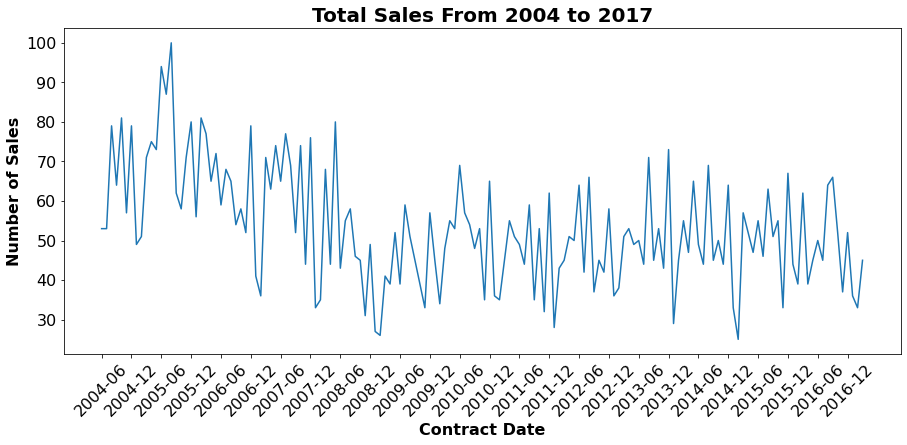

In [4]:
#graph time plot of data to examine vehicle sales yearly/monthly
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(ts['ContractYearMonth'], ts['TotalSales'])
x_ticks = np.arange(0,153,6) #start at index 0, stop at 153, and step up by 6
plt.xticks(x_ticks, rotation = 45)

ax.set_title('Total Sales From 2004 to 2017', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Contract Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Number of Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

#### Dealership Time Series Decomposition

In [5]:
#create datetimeindex of dataset
ts_dt=ts
ts_dt['date'] = pd.to_datetime(ts_dt['ContractYearMonth'])
ts_dt = ts_dt.drop(columns=['ContractYearMonth'])
ts_dt = ts_dt.set_index('date')
ts_dt

,TotalSales
date,
2004-06-01,53
2004-07-01,53
2004-08-01,79
2004-09-01,64
2004-10-01,81
...,...
2016-11-01,37
2016-12-01,52
2017-01-01,36


Text(0.5, 0.98, 'Total Dealership Sales Decomposition')

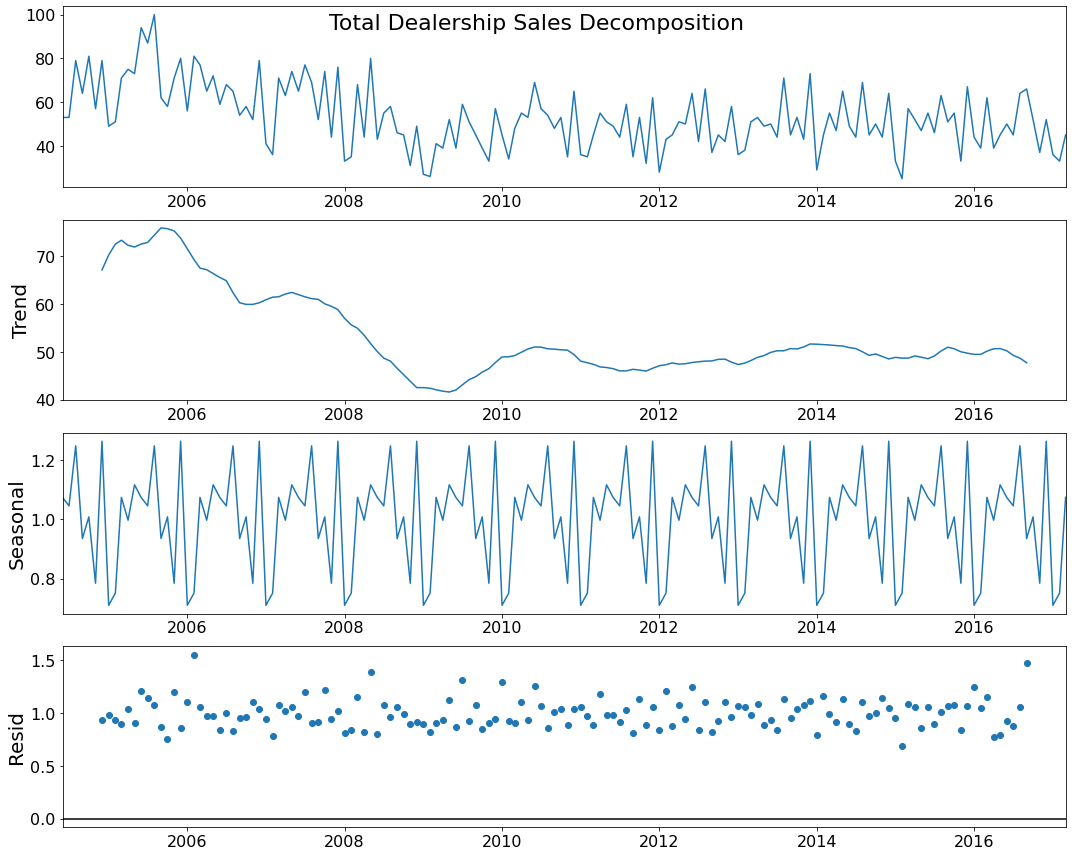

In [6]:
#multiplicative model decomposition plot
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomposition = sm.tsa.seasonal_decompose(ts_dt, model='multiplicative')
decomp = decomposition.plot()
decomp.suptitle('Total Dealership Sales Decomposition', fontsize=22)

We can see from the plots above that the series has a clear downward trend and seasonality which suggests that the time series is non-stationary. However, lets confirm so in this notebook using the ADFuller test. Why? Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

#### Lexus Time Plot

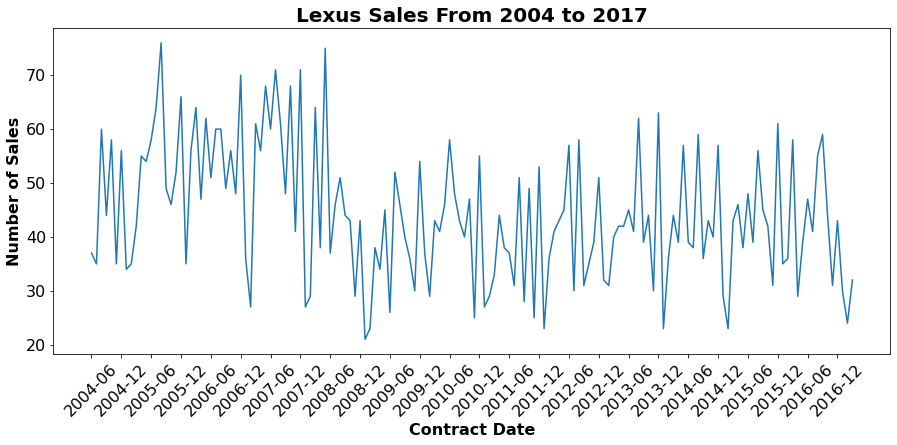

In [7]:
#graph time plot of data to examine vehicle sales yearly/monthly for lexus vehicles only
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(lx['ContractYearMonth'], lx['TotalSales'])
x_ticks = np.arange(0,153,6) #start at index 0, stop at 153, and step up by 6
plt.xticks(x_ticks, rotation = 45)

ax.set_title('Lexus Sales From 2004 to 2017', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Contract Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Number of Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

#### Lexus Time Series Decomposition

In [8]:
#convert "lx" ContractYearMonth to a pandas DatetimeIndex
lex = lx.copy()
lex['date'] = pd.to_datetime(lex['ContractYearMonth'])
lex = lex.drop(columns=['ContractYearMonth'])
lex = lex.set_index('date')
lex

,TotalSales
date,
2004-06-01,37
2004-07-01,35
2004-08-01,60
2004-09-01,44
2004-10-01,58
...,...
2016-11-01,31
2016-12-01,43
2017-01-01,30


Text(0.5, 0.98, 'Lexus Sales Decomposition')

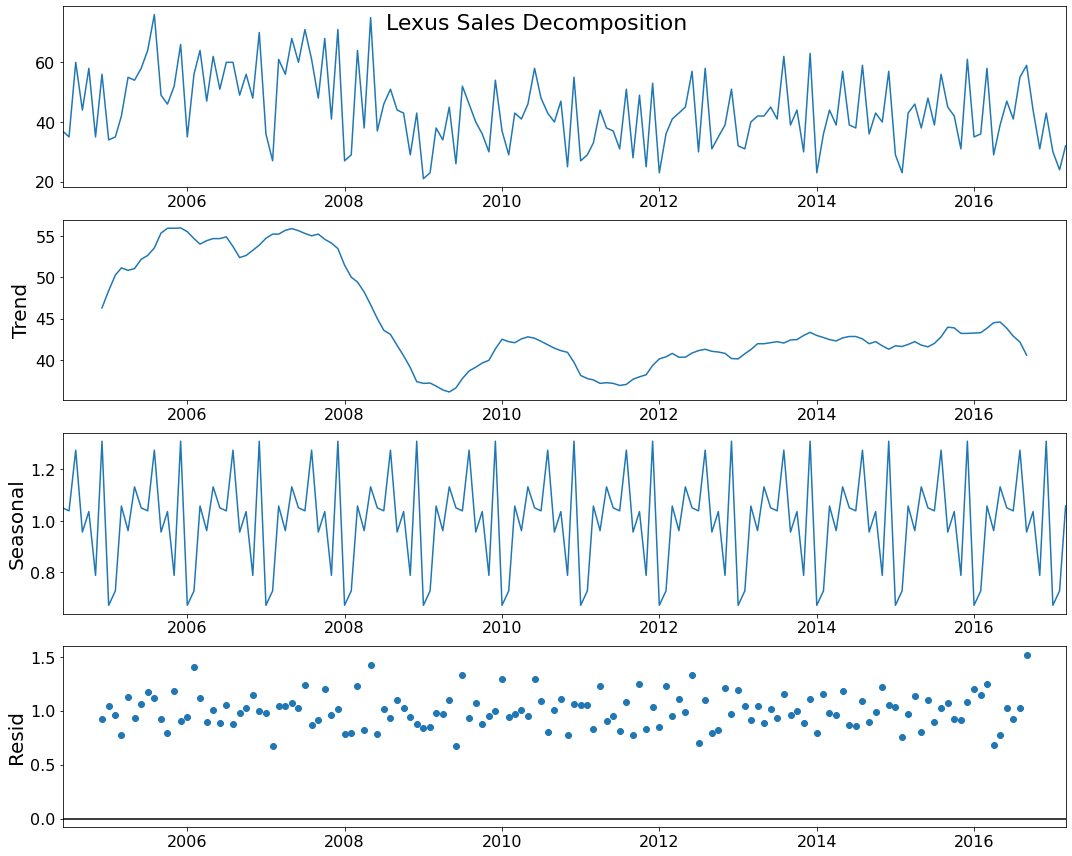

In [9]:
#lexus multiplicative model decomposition plot
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomposition = sm.tsa.seasonal_decompose(lex, model='multiplicative')
decomp = decomposition.plot()
decomp.suptitle('Lexus Sales Decomposition', fontsize=22)

From this time plot we can the strong seasonality within each year, as seen in the dealership total sales time plot. The downward trend observed in the dealership total sales time plot is even more obvious when examining Lexus vehicle sales exclusively. The same downward trend appears to begin in the first quarter of 2008 with it's lowest plunge at the start of 2009. 

In addition, 2005 and 2006, as seen in the dealership total sales time plot, still appear to have outliers and values which need to be explained because they differ from the seasonality or trend of any other years. There are also missing observations from January to May of 2004 and the second quarter of 2017 and onward. Also there is a clear decreasing fluctuation in in the third quarter of 2008, which coincides with the financial crisis of 2007-2008 in the United States.

### ADFuller Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the time series is stationary or non-stationary data.

The **null hypothesis** of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if p-value > 0.05 we go ahead with finding the order of differencing.

#### Dealership ADF Test

In [10]:
result = adfuller(ts.TotalSales.ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.586742
p-value: 0.095768
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


Since the p-value (0.09) is greater than the significance level (0.05) then **the null hypothesis is accepted** stating the time series is indeed non-stationary and the alternative hypthesis rejected. 

#### Lexus ADF Test

In [11]:
#perform ADFuller test on Lexus df containing year and month of sales
result = adfuller(lex['TotalSales'].ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.786583
p-value: 0.387143
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578


Since the p-value = 0.387143 is greater than the significance level (0.05), therefore **the null hypothesis is accepted** and the time series appears also non-stationary.

Now, let's examine the seasonality of the time series to determine an essential parameter for our ARIMA model,**(m), which is the seasonal period.** To do this, we will use an autocorrelation plot to determine this value.

## 4.6 Baseline Models

A baseline in forecast performance provides a point of comparison.

It is a point of reference for all other modeling techniques on our problem. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned.

The goal is to get a baseline performance on our time series forecast problem as quickly as possible so that you can get to work better understanding the dataset and developing more advanced models.

In this section, the following four methods will be explored as baseline models: **Simple Average, Naive, SARIMAX, and Holts-Winter's.**

### 4.6.1 Train/Test Split

#### Dealership Split

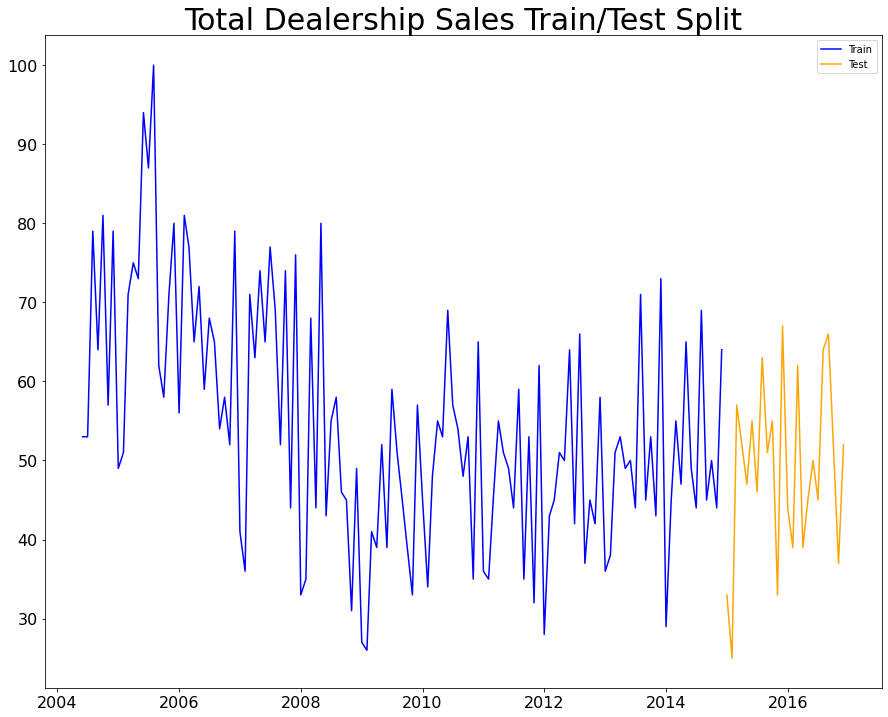

In [12]:
#divide "ts_dt" df into train and test set
train = ts_dt['2004':'2014']
test = ts_dt['2015':'2016']

#plot train/valid split
plt.plot(train, 'blue', test,'orange')
plt.legend(["Train","Test"])
plt.title('Total Dealership Sales Train/Test Split', fontsize=30)
plt.show() 

#### Lexus Split

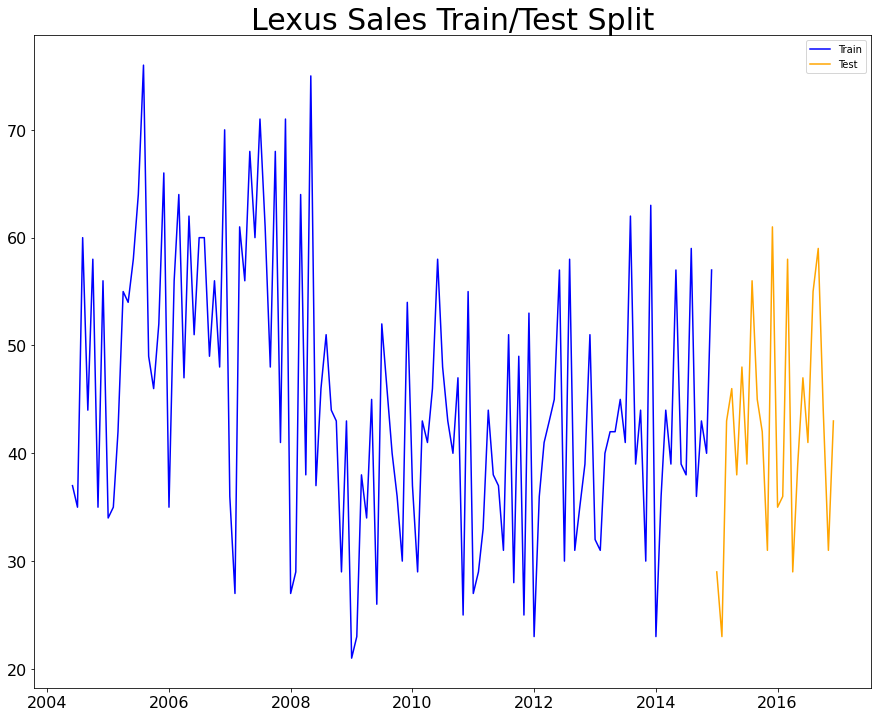

In [13]:
#divide "lex" df into train and test set
train_lex = lex['2004':'2014']
test_lex = lex['2015':'2016']

#plot train/valid split
plt.plot(train_lex, 'blue', test_lex,'orange')
plt.legend(["Train","Test"])
plt.title('Lexus Sales Train/Test Split', fontsize=30)
plt.show() 

### 4.6.2 Method 1: Simple Average

With the Simple Average method forecasts of all future values are equal to the average (or “mean”) of the historical data.

#### Dealership Average

,Method,RMSE,MAPE
0,Simple Average,12.17,24.471189


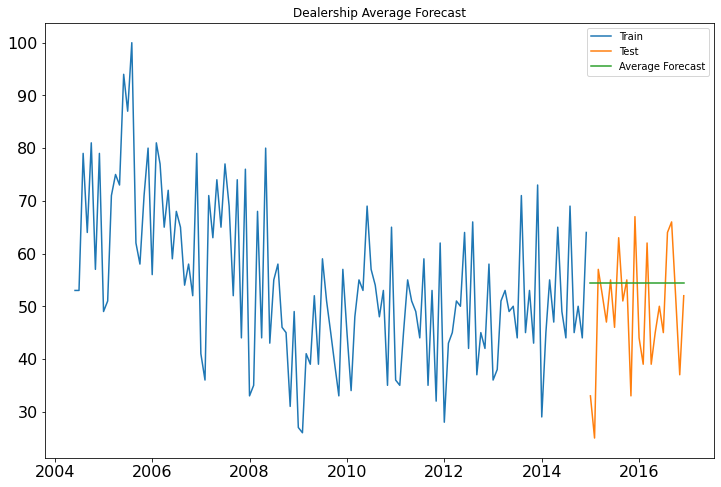

In [14]:
#model
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['TotalSales'].mean()

#plot
plt.figure(figsize=(12,8))
plt.plot(train['TotalSales'], label='Train')
plt.plot(test['TotalSales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title("Dealership Average Forecast")

#evaluation
#function to create MAPE 
def cal_mape(actuals, predictions):
  num = abs(actuals - predictions)
  den = actuals
  ape = (num*100)/den
  return np.mean(ape)

mse = mean_squared_error(test.TotalSales, y_hat_avg.avg_forecast)
rmse = np.sqrt(mse).round(2)
mape = cal_mape(test.TotalSales, y_hat_avg.avg_forecast)

#create pd.DataFrame of evaluations
Dlr_MAPE_df = pd.DataFrame({'Method':['Simple Average'], 'RMSE':[rmse], 'MAPE' : [mape]})
Dlr_MAPE_df

#### Lexus Average

,Method,RMSE,MAPE
0,Simple Average,10.38,22.993712


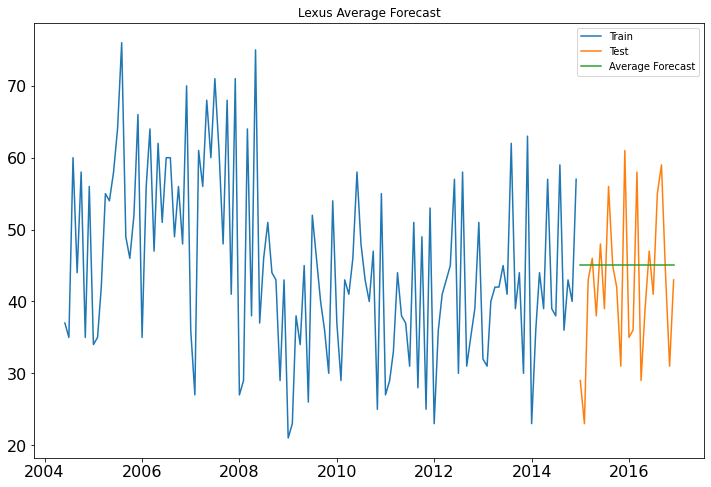

In [15]:
#model
y_hat_lex_avg = test_lex.copy()
y_hat_lex_avg['avg_forecast'] = train_lex['TotalSales'].mean()

#plot
plt.figure(figsize=(12,8))
plt.plot(train_lex['TotalSales'], label='Train')
plt.plot(test_lex['TotalSales'], label='Test')
plt.plot(y_hat_lex_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title("Lexus Average Forecast")

#evaluation
mse = mean_squared_error(test_lex.TotalSales, y_hat_lex_avg.avg_forecast)
rmse = np.sqrt(mse).round(2)
mape = cal_mape(test_lex.TotalSales, y_hat_lex_avg.avg_forecast)

#create pd.DataFrame of evaluations
Lxs_MAPE_df = pd.DataFrame({'Method':['Simple Average'], 'RMSE':[rmse], 'MAPE' : [mape]})
Lxs_MAPE_df

### 4.6.3 Method 2: Naive

The Naive method is an estimating technique in which the last period's actuals are used as this period's forecast, without adjusting them or attempting to establish causal factors.

#### Dealership Naive

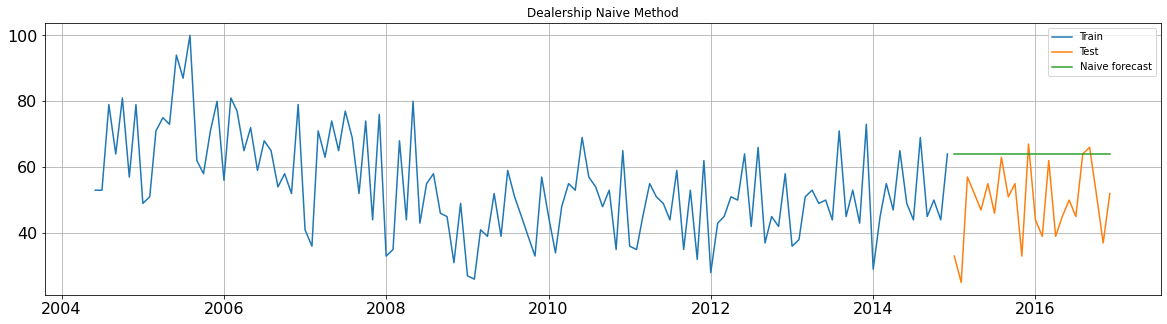

,Method,RMSE,MAPE
0,Simple Average,12.17,24.471189
0,Naive,18.47,38.762770


In [16]:
#model
train_len = len(train)
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['TotalSales'][train_len-1]

#plot
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['TotalSales'], label='Train')
plt.plot(test['TotalSales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Dealership Naive Method')
plt.show()

#evaluation
mse = mean_squared_error(test['TotalSales'], y_hat_naive.naive_forecast)
rmse = np.sqrt(mse).round(2)
mape = cal_mape(test['TotalSales'], y_hat_naive.naive_forecast)

#join results
DlrResults = pd.DataFrame({'Method':['Naive'], 'RMSE': [rmse],'MAPE': [mape]})
Dlr_MAPE_df = pd.concat([Dlr_MAPE_df, DlrResults])
Dlr_MAPE_df

#### Lexus Naive

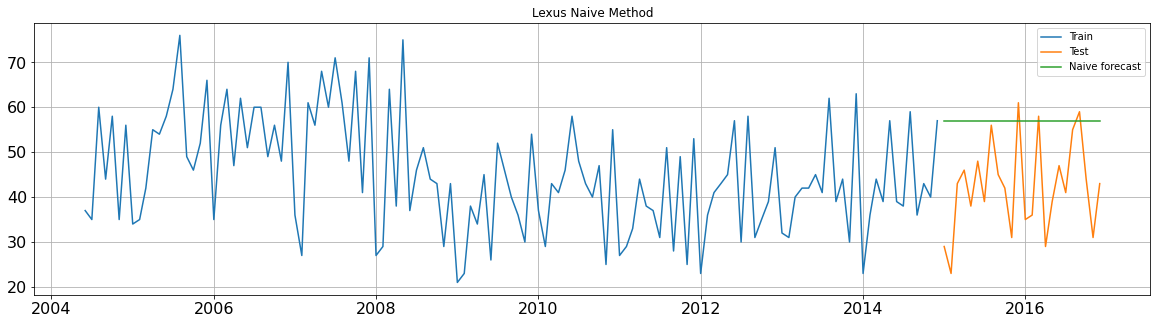

,Method,RMSE,MAPE
0,Simple Average,10.38,22.993712
0,Naive,17.71,43.719574


In [17]:
#model
train_lex_len = len(train_lex)
y_hat_lex_naive = test_lex.copy()
y_hat_lex_naive['naive_forecast'] = train_lex['TotalSales'][train_lex_len-1]

#plot
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train_lex['TotalSales'], label='Train')
plt.plot(test_lex['TotalSales'], label='Test')
plt.plot(y_hat_lex_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Lexus Naive Method')
plt.show()

#evaluation
mse = mean_squared_error(test_lex['TotalSales'], y_hat_lex_naive.naive_forecast)
rmse = np.sqrt(mse).round(2)
mape = cal_mape(test_lex['TotalSales'], y_hat_lex_naive.naive_forecast)

#join results
LxsResults = pd.DataFrame({'Method':['Naive'], 'RMSE': [rmse],'MAPE': [mape]})
Lxs_MAPE_df = pd.concat([Lxs_MAPE_df, LxsResults])
Lxs_MAPE_df

### 4.6.4 Method 3: SARIMAX

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.

Although the method can handle data with a trend, it does not support time series with a seasonal component.

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called Seasonal Autoregressive Integrated Moving Average, or SARIMA.

To begin prepping the data for the next model, we must first define one of the key parameters for an ARIMA model, (m). This parameter represents the number of time steps for a single seasonal period and is key in establishing an accurate ARIMA model. To tackle this task, we will use an autocorrelation plot, or ACF.

#### 4.6.4.1 Autocorrelation (ACF) Plot 

Autocorrelation plots are plots that graphically summarize and calculate the correlation for time series observations with observations with previous time steps, called lags. A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. Using the plot_acf() function will create a plot showing the lag value along the x-axis and the correlation on the y-axis between -1 and 1. Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

**The goal of using the ACF plot is to identify at what lag number we observe the greatest autocorrelation. This lag number will be the value we use for our (m) parameter in our ARIMA model.**

#### Dealership ACF Plot

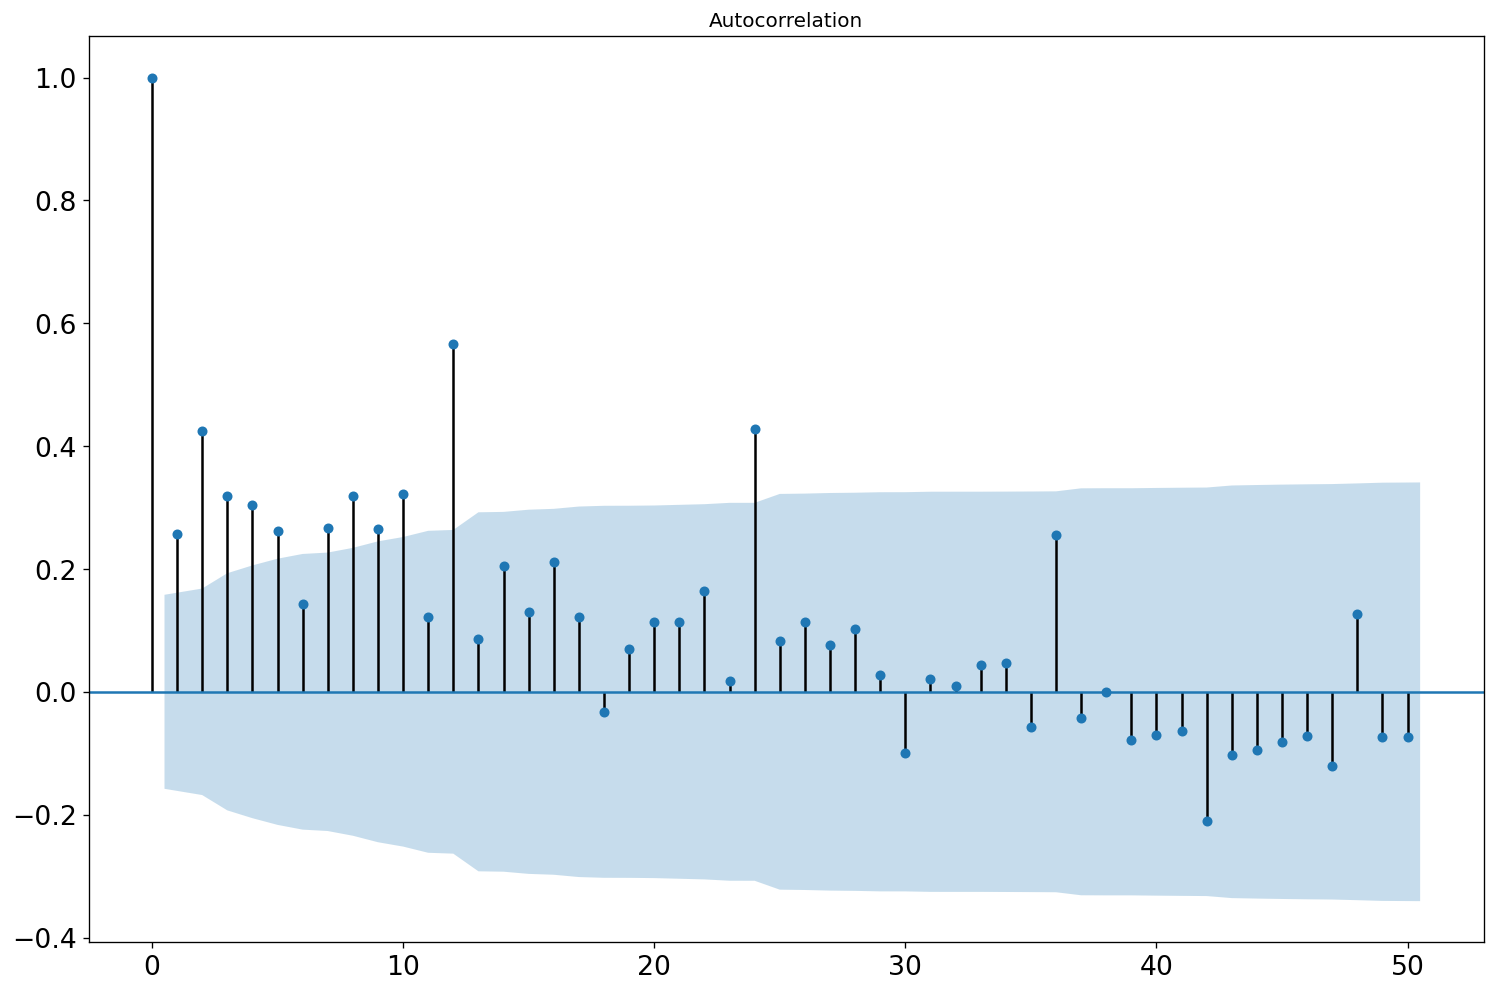

In [18]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

f_acf = plot_acf(ts.TotalSales, lags=50)
f_acf.set_figheight(10)
f_acf.set_figwidth(15)

plt.show()

From the ACF plot we can see that our greatest autocorrelation is at lag number 12. Therefore, we have a **(m) value of 12**, which makes since given this is monthly data. 

#### Lexus ACF Plot

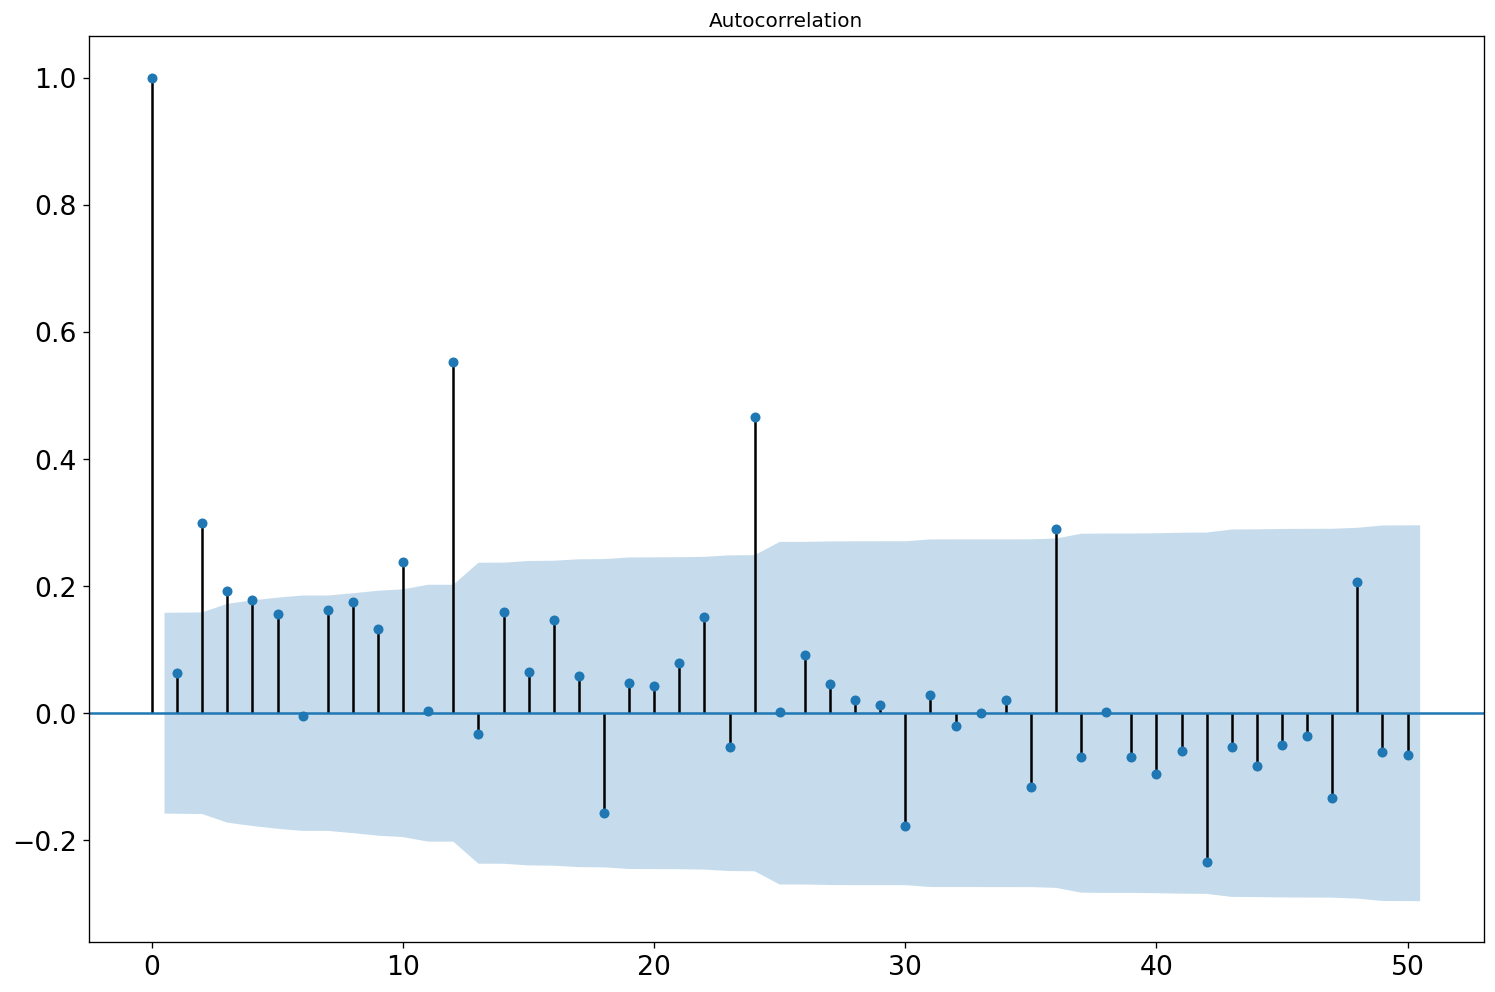

In [19]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

f_acf = plot_acf(lex.TotalSales, lags=50)
f_acf.set_figheight(10)
f_acf.set_figwidth(15)

plt.show()

Same result as seen for dealership, which makes sense. 

Now, we need to determine the remaining order of each parameter for our model. To do so, we will use a “grid search” to iteratively explore different combinations of parameters and programmatically select the optimal parameter values for our time series model.

#### 4.6.4.2 Parameter Estimation (Grid Search)

#### What is an ARIMA model?

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. The 'AR' stands for "autoregression, the 'I' for "integrated, and the 'MA' for "moving average. Each of these components are explicitly specified in the model as a parameter. The parameters of the ARIMA model are defined as follows: (p) is the number of autoregressive lags, (d) is the order of differencing required to make the series stationary, and (q) is the number of moving average lags. 

However, we know this data has seasonality as well, so the Seasonal ARIMA model [SARIMAX] will be used to account for seasonal differencing. Therefore, the model we will use is represented by SARIMAX(p,d,q)(P,D,Q)m, where(P,D,Q)m represents the seasonal parameter of (p,d,q) and (m) the number of time steps for a single seasonal period. Since the time series is observed monthly, (m) will be set to 12, representing each month of a year.

#### How does an auto_arima( ) function work?

To discover the optimal order for an ARIMA model the auto_arima() function from the pmdarima library is utilized. The auto_arima() function works by conducting differencing tests to determine the order of differencing (d), and then fitting models within ranges of defined possibilities. If the *seasonal* option is enabled, the auto_arima() function also seeks to identify the optimal (P) and (Q) hyperparameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing (D). In order to find the best model the auto_arima() function optimizes for a given information_criterion, one of {‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’}, in this case we will use AIC, and returns the ARIMA which minimizes that value.

The purpose of using the auto_arima() function is not only to help us determine the order of each parameter for our model, but also it chooses the parameters that help make our time series stationary.

#### Dealership Grid Search

In [20]:
#grid searching parameters
arima_model_dlr = auto_arima(ts.TotalSales, start_p=0, start_d=0, start_q=0, max_p=10,max_q=10, start_P=0, start_D=0, start_Q=0,max_P=10, max_Q=10,m=12,
                         seasonal=True,trace=True,error_action='warn',suppress_warnings=True,stepwise=True)

#Summary of the model
arima_model_dlr.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1319.132, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1185.775, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1193.842, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1317.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1248.435, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1174.168, Time=0.29 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=1172.918, Time=0.71 sec
 ARIMA(1,1,0)(4,0,0)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(4,0,1)[12] intercept   : AIC=inf, Time=4.37 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=1232.805, Time=0.41 sec
 ARIMA(2,1,0)(3,0,0)[12] intercept   : AIC=1164.040, Time=0.64 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1164.771, Time=0.34 sec
 ARIMA(2,1,0)(4,0,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  154
Model:             SARIMAX(2, 1, 1)x(3, 0, 1, 12)   Log Likelihood                -565.886
Date:                            Wed, 23 Jun 2021   AIC                           1149.771
Time:                                    01:48:20   BIC                           1177.045
Sample:                                         0   HQIC                          1160.850
                                            - 154                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0008      0.004     -0.240      0.811      -0.008       0.006
ar.L1          0.1315      0.086      1.537      0.124      -0.036       0.299
ar.L2          0.3016      0.083      3.620      0.000       0.138       0.465
ma.L1         -0.9490      0.032    -29.553      0.000      -1.012      -0.886
ar.S.L12       1.0454      0.222      4.710      0.000       0.610       1.480
ar.S.L24       0.0013      0.133      0.009      0.992      -0.260       0.262
ar.S.L36      -0.0584      0.129     -0.454      0.650      -0.311       0.194
ma.S.L12      -0.8632      0.275     -3.139      0.002      -1.402      -0.324
sigma2        86.3713     13.015      6.636      0.000      60.862     111.880
===================================================================================
Ljung-Box (Q):                       36.71   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.62   Prob(JB):                         0.88
Heteroskedasticity (H):               0.43   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The output of our grid search suggests that the best ARIMA model is a SARIMAX model with the ordered parameters of (2,1,1)(3,0,1)[12] which yields the lowest AIC value of 1149.77. We should therefore consider this to be optimal model parameters out of all the models considered.

#### Lexus Grid Search

In [21]:
#grid searching parameters
arima_model_lex = auto_arima(lx.TotalSales, start_p=0, start_d=0, start_q=0, max_p=10,max_q=10, start_P=0, start_D=0, start_Q=0,max_P=10, max_Q=10,m=12,
                         seasonal=True,trace=True,error_action='warn',suppress_warnings=True,stepwise=True)

#Summary of the model
arima_model_lex.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1304.569, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1170.623, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1169.412, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1302.569, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1196.999, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1149.502, Time=0.30 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,1)(0,0,3)[12] intercept   : AIC=1141.293, Time=0.75 sec
 ARIMA(0,1,1)(1,0,3)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,1,1)(0,0,4)[12] intercept   : AIC=1136.992, Time=1.73 sec
 ARIMA(0,1,1)(1,0,4)[12] intercept   : AIC=inf, Time=4.58 sec
 ARIMA(0,1,1)(0,0,5)[12] intercept   : AIC=1138.919, Time=2.59 sec
 ARIMA(0,1,1)(1,0,5)[12] intercept   : AIC=1126.647, Time=7.18 sec
 ARIMA(0,1,1)(2,0,5)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                                y   No. Observations:                  154
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2, 3, 4, 5], 12)   Log Likelihood                -554.323
Date:                                          Wed, 23 Jun 2021   AIC                           1126.647
Time:                                                  01:50:29   BIC                           1153.921
Sample:                                                       0   HQIC                          1137.726
                                                          - 154                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.008     -0.082      0.935      -0.017       0.016
ma.L1         -0.8112      0.048    -16.931      0.000      -0.905      -0.717
ar.S.L12       0.9794      0.060     16.218      0.000       0.861       1.098
ma.S.L12      -0.8088      0.173     -4.666      0.000      -1.148      -0.469
ma.S.L24       0.0178      0.115      0.155      0.877      -0.207       0.242
ma.S.L36      -0.1157      0.117     -0.990      0.322      -0.345       0.113
ma.S.L48       0.0469      0.149      0.315      0.753      -0.245       0.339
ma.S.L60       0.0491      0.144      0.342      0.733      -0.233       0.331
sigma2        73.2490     11.192      6.545      0.000      51.314      95.184
===================================================================================
Ljung-Box (Q):                       37.93   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.56   Prob(JB):                         0.44
Heteroskedasticity (H):               0.51   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The output of our grid search suggests that the best ARIMA model is a SARIMAX model with the ordered parameters of (0,1,1)(1,0,5)[12] which yields the lowest AIC value of 1126.6. We should therefore consider this to be optimal model parameters out of all the models considered.

#### 4.6.4.3 SARIMAX Model Fit

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We’ll start by plugging the optimal parameter values into a new SARIMAX model:

#### Dealership Model Fit

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0396      0.125     -0.317      0.751      -0.284       0.205
ar.L2          0.1552      0.128      1.213      0.225      -0.095       0.406
ma.L1         -0.8184      0.082    -10.015      0.000      -0.979      -0.658
ar.S.L12       1.0288      0.122      8.463      0.000       0.791       1.267
ar.S.L24       0.0627      0.095      0.663      0.507      -0.123       0.248
ar.S.L36      -0.0924      0.040     -2.332      0.020      -0.170      -0.015
ma.S.L12      -0.9609      0.507     -1.897      0.058      -1.954       0.032
sigma2        79.3088     31.331      2.531      0.011      17.902     140.716


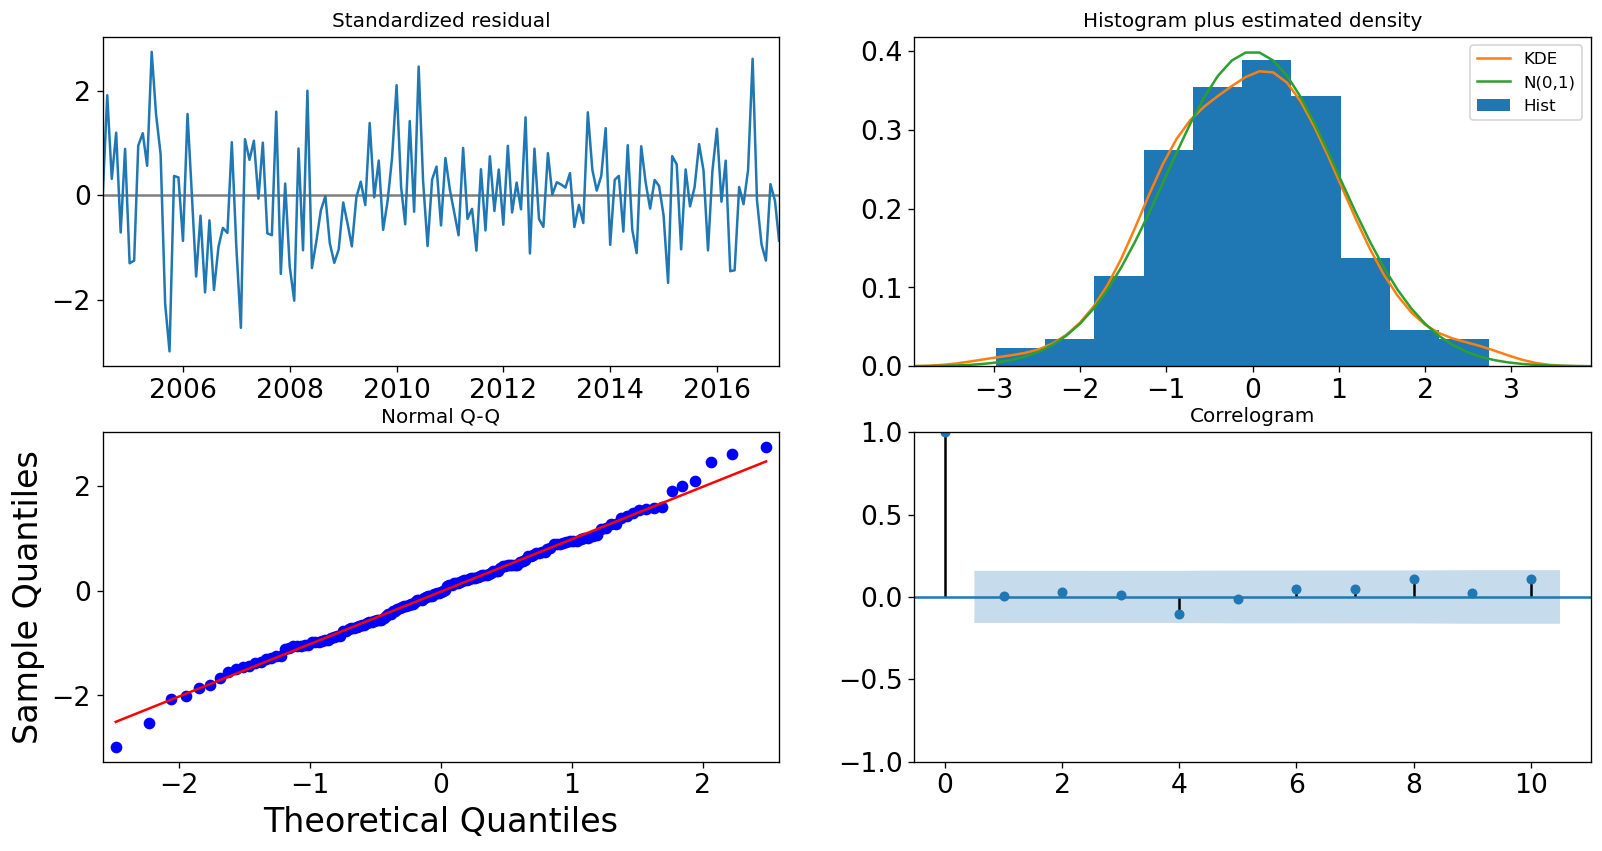

In [22]:
mod_dlr = sm.tsa.statespace.SARIMAX(ts_dt,
                                freq = 'MS',
                                order=(2, 1, 1),
                                seasonal_order=(3, 0, 1, 12))

model_fit_dlr = mod_dlr.fit(disp=False)

print(model_fit_dlr.summary().tables[1])

#model diagnostics
model_fit_dlr.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Lexus Model Fit

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8221      0.046    -17.869      0.000      -0.912      -0.732
ar.S.L12       0.9987      0.031     32.520      0.000       0.939       1.059
ma.S.L12      -0.8809      0.481     -1.832      0.067      -1.823       0.061
ma.S.L24       0.0412      0.117      0.353      0.724      -0.188       0.270
ma.S.L36      -0.1477      0.130     -1.134      0.257      -0.403       0.108
ma.S.L48       0.0102      0.146      0.070      0.944      -0.276       0.297
ma.S.L60       0.0288      0.123      0.234      0.815      -0.213       0.271
sigma2        68.9731     27.807      2.480      0.013      14.473     123.474


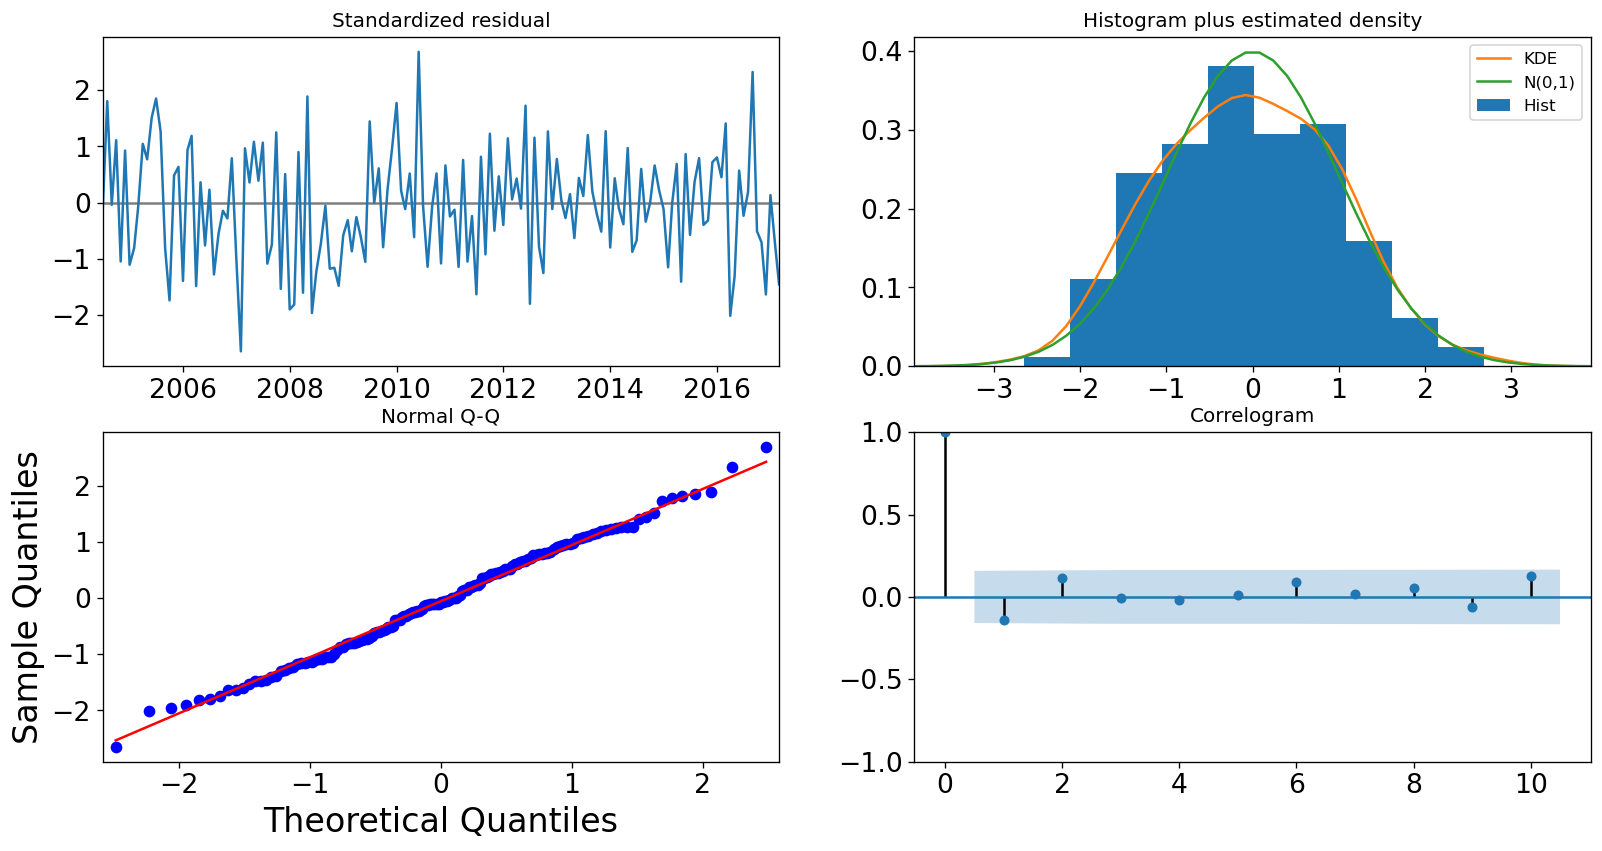

In [23]:
mod_lex = sm.tsa.statespace.SARIMAX(lex,
                                freq = 'MS',
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 5, 12))

model_fit_lex = mod_lex.fit(disp=False)

print(model_fit_lex.summary().tables[1])

#model diagnostics
model_fit_lex.plot_diagnostics(figsize=(16, 8))
plt.show()

From the summary tables for both datasets we can see that the coef column shows the weight (importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, most of the weights have a p-value lower than 0.05, so it is reasonable to retain most of them in our model.

Our primary concern now, is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that both model residuals are normally distributed based on the following:

 - In the top left plot, we see the residuals over time don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
 
    
 - In the top right plot, we see that the orange KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
 
    
 - The normal qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
 

Those observations lead us to conclude that both of our models produce a satisfactory fit that could help us understand our time series data and forecast future values.

#### 4.6.4.4 Validating SARIMAX Predictions

We have obtained a model for both of our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our predictions. The *get_prediction()* and *conf_int()* attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

#### Dealership Prediction

In [24]:
pred_dlr = model_fit_dlr.get_prediction(start=pd.to_datetime('2015-01'), dynamic=False) #our test data
pred_ci_dlr = pred_dlr.conf_int()

The code above requires the prediction to start at January 2015.

The *dynamic=False* argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point. We'll plot the real and predicted values of the time series to assess how well we did.

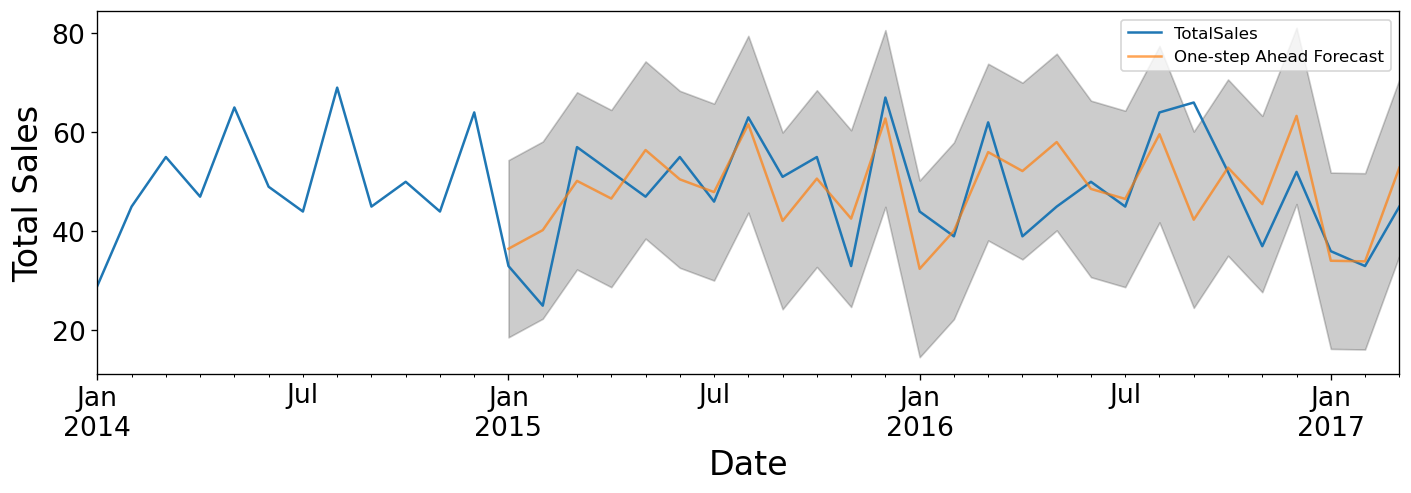

In [25]:
ax = ts_dt['2014':].plot(label='observed')
pred_dlr.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha = .7, figsize=(14, 4))
ax.fill_between(pred_ci_dlr.index,
                pred_ci_dlr.iloc[:, 0],
                pred_ci_dlr.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()

#### Lexus Prediction

In [26]:
pred_lex = model_fit_lex.get_prediction(start=pd.to_datetime('2015-01'), dynamic=False) #our test data
pred_ci_lex = pred_lex.conf_int()

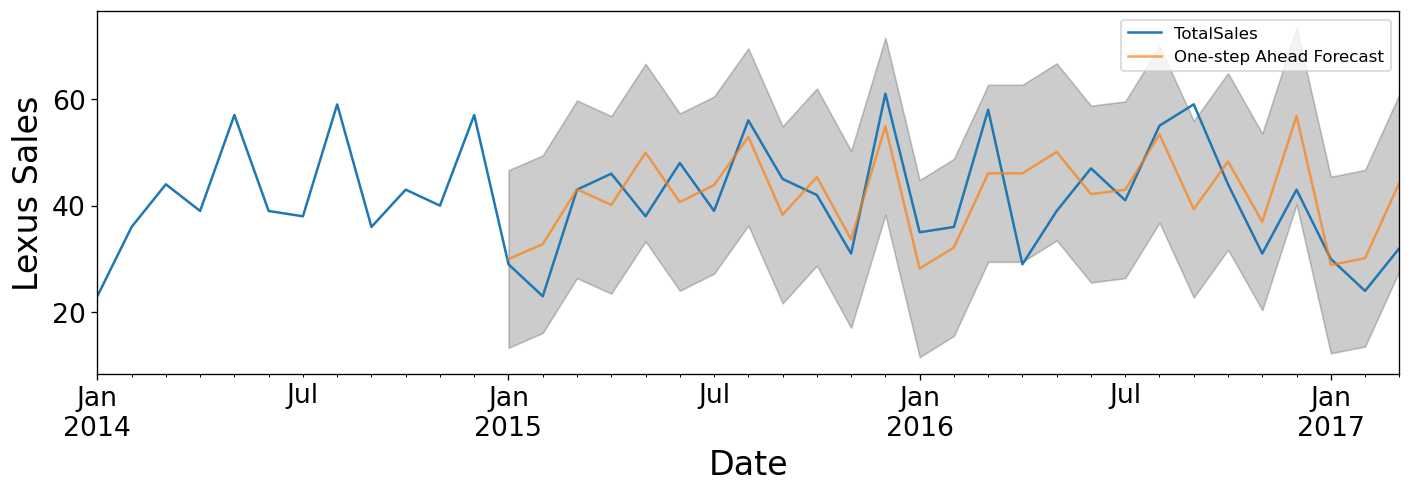

In [27]:
ax = lex['2014':].plot(label='observed')
pred_lex.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha = .7, figsize=(14, 4))
ax.fill_between(pred_ci_lex.index,
                pred_ci_lex.iloc[:, 0],
                pred_ci_lex.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Lexus Sales')
plt.legend()
plt.show()

This step compared the true values with the forecasted predictions. Our predictions fit with the true values fairly well. The command “model_fit.get_prediction(start=pd.to_datetime('2015-01'), dynamic=False)” determined the period to predict within compared with the true data from that same period. Now, lets train/test split our data on our defined model and then forecast future sales. 

#### 4.6.4.5 SARIMAX Model Training

#### Dealership Training

In [28]:
model = SARIMAX(train, freq='MS', order=(2, 1, 1), seasonal_order=(3, 0, 1, 12))
model_fit = model.fit(disp=False) 

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


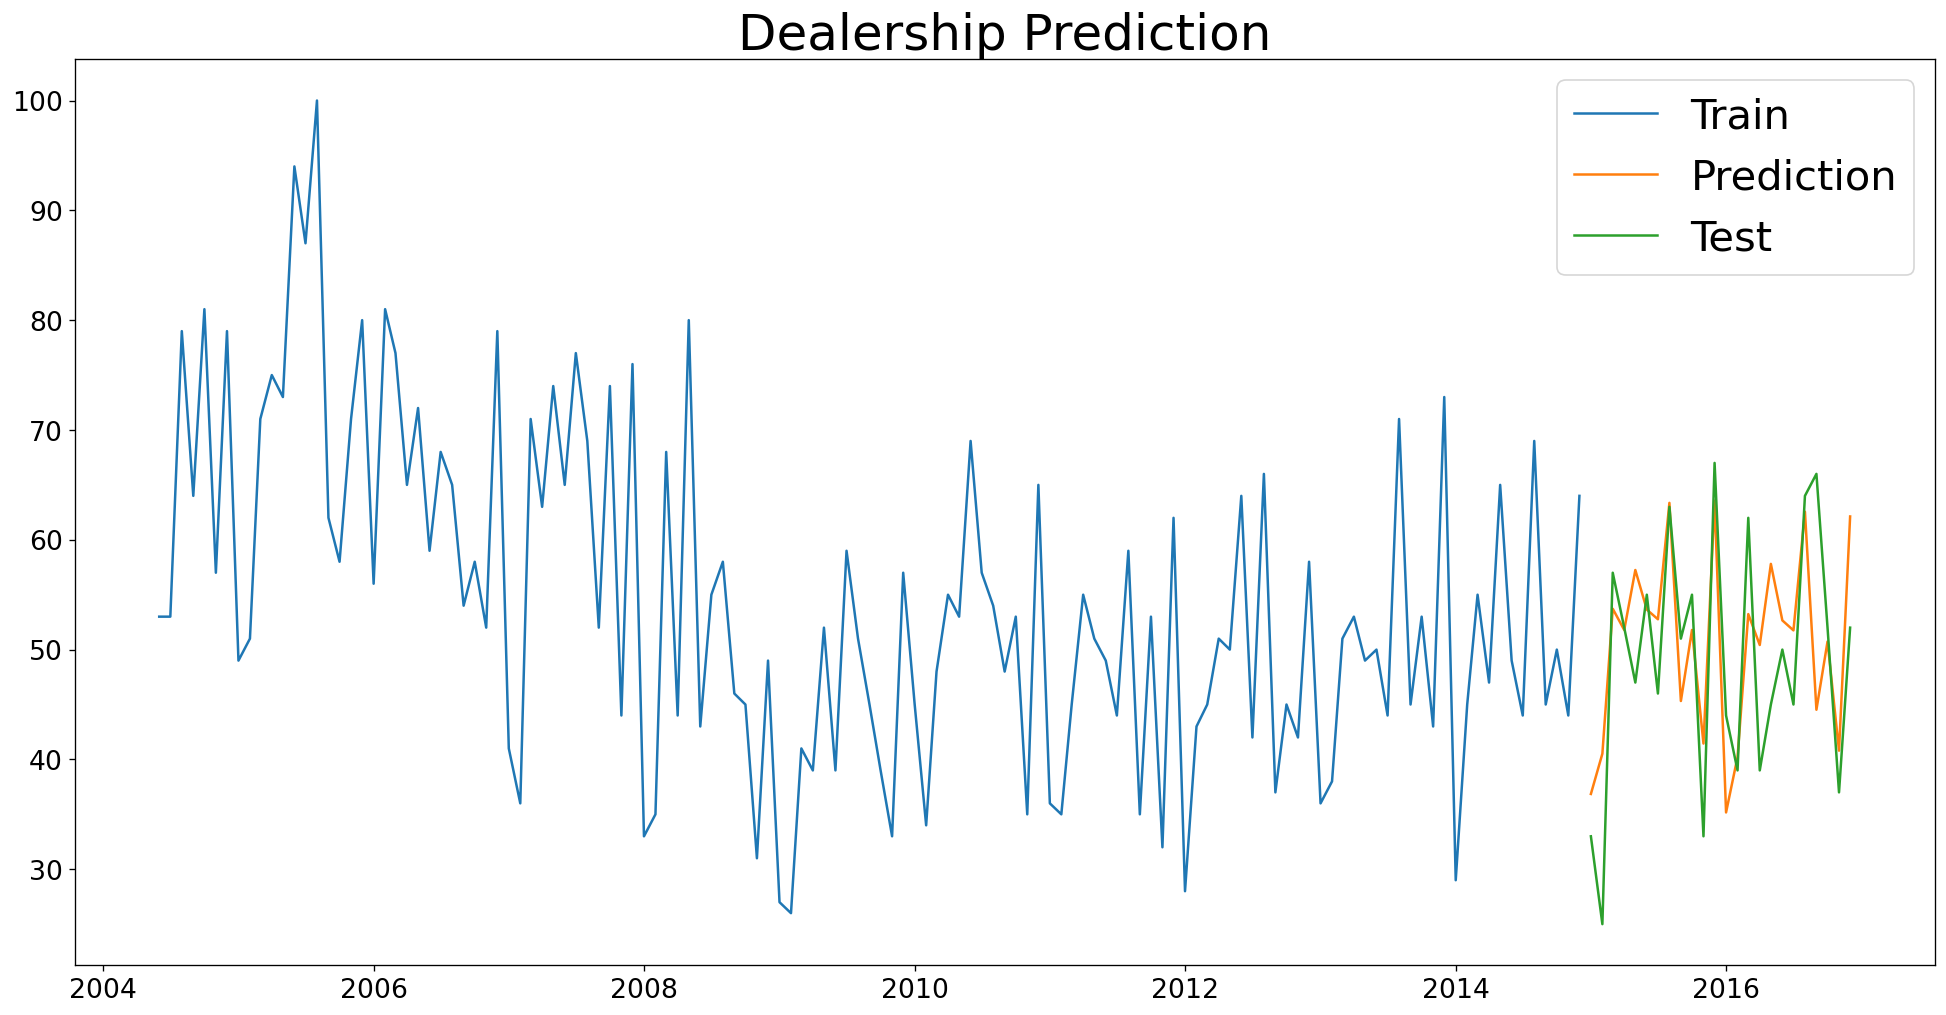

,Method,RMSE,MAPE
0,Simple Average,12.170000,24.471189
0,Naive,18.470000,38.762770
0,SARIMAX,8.241263,14.562545


In [29]:
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len) 

#plot
plt.figure(figsize=(20, 10))
plt.title('Dealership Prediction', fontsize=30)
plt.plot(train, label='Train')
plt.plot(fcast, label='Prediction')
plt.plot(test, label='Test')
plt.legend(fontsize=25)
plt.show()

#evaluation
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mape = cal_mape(test.TotalSales, fcast)

#join results
DlrResults = pd.DataFrame({'Method':['SARIMAX'], 'RMSE': [rmse],'MAPE': [mape]})
Dlr_MAPE_df = pd.concat([Dlr_MAPE_df, DlrResults])
Dlr_MAPE_df

#### Lexus Training

In [30]:
model_lex = SARIMAX(train_lex, freq='MS', order=(0, 1, 1), seasonal_order=(1, 0, 5, 12))
model_fit_lex = model_lex.fit(disp=False) 

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


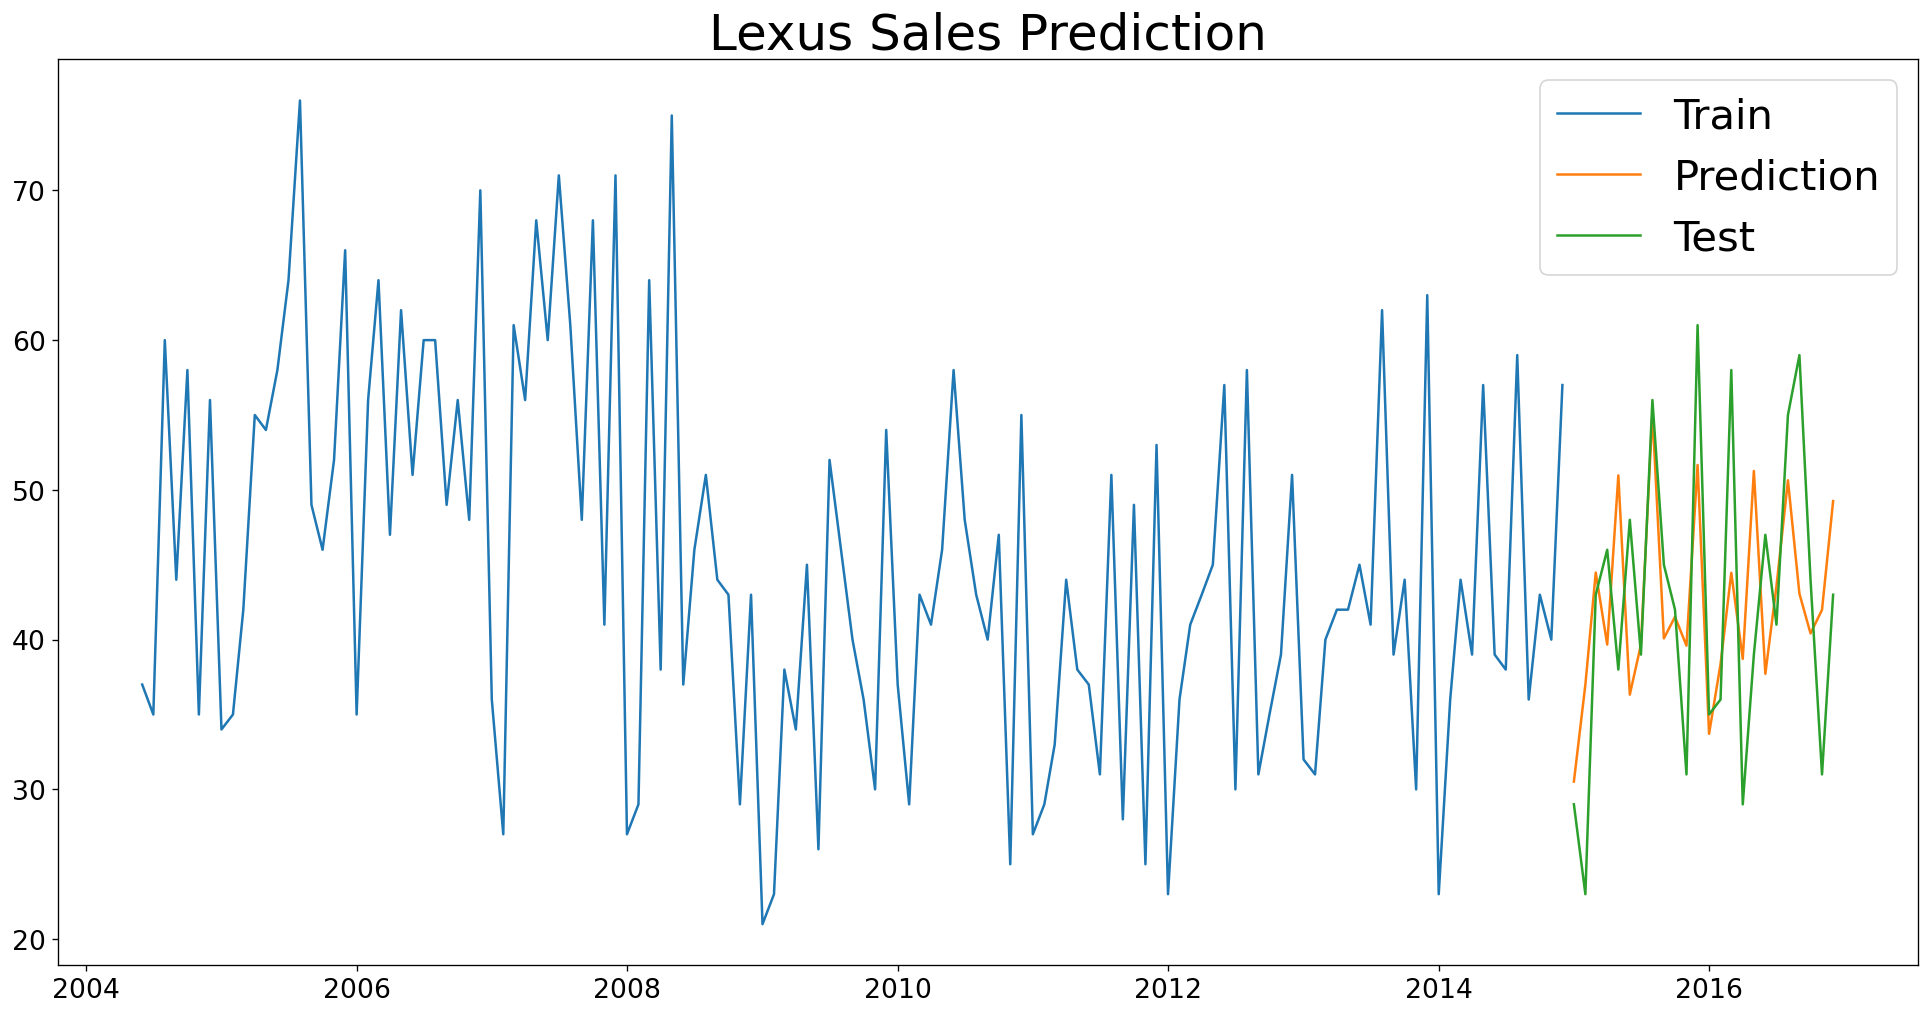

,Method,RMSE,MAPE
0,Simple Average,10.380000,22.993712
0,Naive,17.710000,43.719574
0,SARIMAX,8.428568,17.403573


In [31]:
fcast_len_lex = len(test_lex)
fcast_lex = model_fit_lex.forecast(fcast_len_lex)

#evaluation
mse = mean_squared_error(test_lex, fcast_lex)
rmse = np.sqrt(mse)
mape = cal_mape(test_lex.TotalSales, fcast_lex)

#plot
plt.figure(figsize=(20, 10))
plt.title('Lexus Sales Prediction', fontsize=30)
plt.plot(train_lex, label='Train')
plt.plot(fcast_lex, label='Prediction')
plt.plot(test_lex, label='Test')
plt.legend(fontsize=25)
plt.show()

#join results
LxsResults = pd.DataFrame({'Method':['SARIMAX'], 'RMSE': [rmse],'MAPE': [mape]})
Lxs_MAPE_df = pd.concat([Lxs_MAPE_df, LxsResults])
Lxs_MAPE_df

#### 4.6.4.6 SARIMAX Model Forecast

Here we will forecast the sales for the next 24 months equivalent to January 2017 through December 2018. This parameter is specified in the line “pred_uc = model_fit.get_forecast(steps=24)” of the code below.

#### Dealership Forecast

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


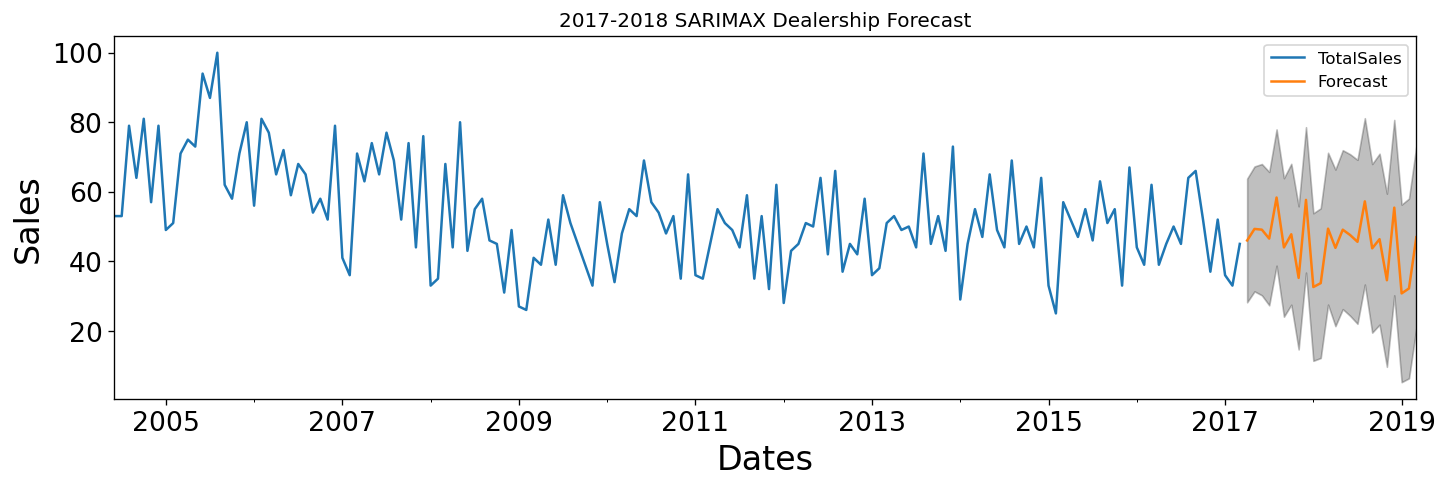

In [32]:
model = sm.tsa.statespace.SARIMAX(ts_dt, freq='MS', order=(2, 1, 1), seasonal_order=(3, 0, 1, 12))
model_fit = model.fit(disp=False) 
pred_uc = model_fit.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = ts_dt.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Dates')
ax.set_ylabel('Sales')
plt.title('2017-2018 SARIMAX Dealership Forecast');
plt.legend()
plt.show()

#### Lexus Forecast

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


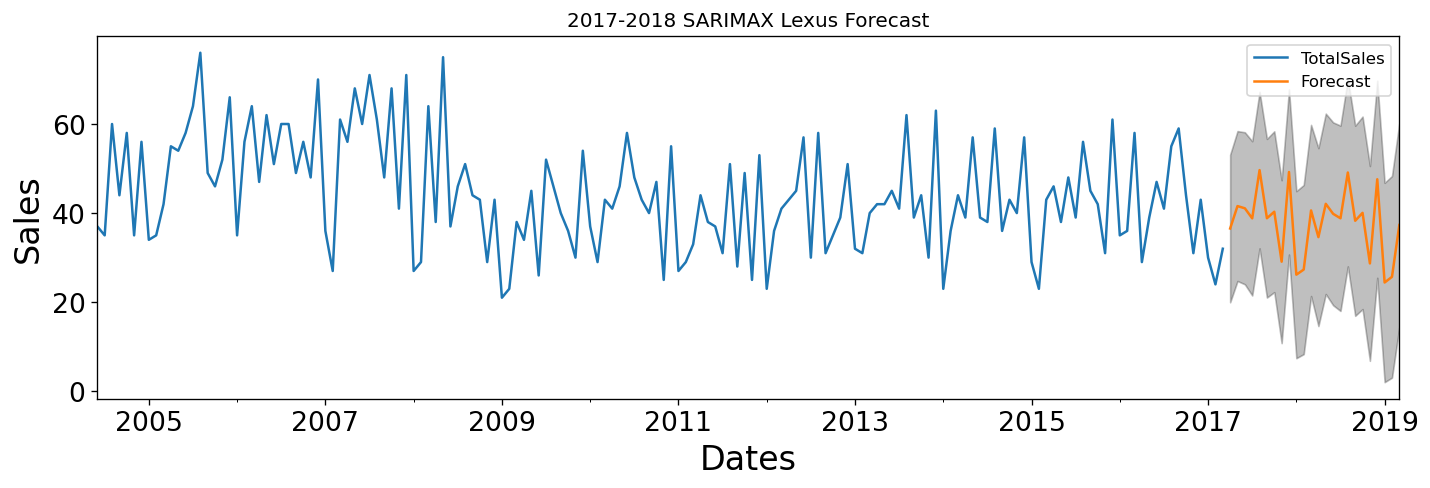

In [33]:
model_lex = sm.tsa.statespace.SARIMAX(lex, freq='MS', order=(0, 1, 1), seasonal_order=(1, 0, 5, 12))
model_fit_lex = model_lex.fit(disp=False) 
pred_uc1 = model_fit_lex.get_forecast(steps=24)
pred_ci1 = pred_uc1.conf_int()
ax = lex.plot(label='observed', figsize=(14, 4))
pred_uc1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Dates')
ax.set_ylabel('Sales')
plt.title('2017-2018 SARIMAX Lexus Forecast');
plt.legend()
plt.show()

### 4.6.5 Method 4: Holt-Winter's

A Holt-Winter's Method (a.k.a. Triple Exponential Smoothing Model) extends Holt to allow the forecasting of time series data that has both trend and seasonality. A Holt-Winter's Exponential Smoothing Model subsumes single and double exponential smoothing by the configuration of the nature of the trend (additive, multiplicative, or none) and the nature of the seasonality (additive, multiplicative, or none), as well as any dampening of the trend.

In this section, 
we will develop a framework for grid searching exponential smoothing model hyperparameters for our given univariate time series. 

Running the block of code below is relatively slow given the large amount of data. Model configurations and the RMSE will be printed as the models are evaluated. The top three model configurations and their error will be reported at the end of the run.

#### 4.6.5.1 Parameter Estimation (Grid Search)

#### Dealership Grid Search

In [ ]:
#one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    #define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    #fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    #make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

#root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

#split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    #split dataset
    train, test = train_test_split(data, n_test)
    #seed history with training dataset
    history = [x for x in train]
    #step over each time-step in the test set
    for i in range(len(test)):
        #fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        #store forecast in list of predictions
        predictions.append(yhat)
        #add actual observation to history for the next loop
        history.append(test[i])
    #estimate prediction error
    error = measure_rmse(test, predictions)
    return error

#score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    #convert config to a key
    key = str(cfg)
    #show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        #one failure during model validation suggests an unstable config
        try:
            #never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    #check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

#grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        #execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    #remove empty results
    scores = [r for r in scores if r[1] != None]
    #sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

#create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    #define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    #create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

if __name__ == '__main__':
    #load dataset
    series = read_csv('../data/processed/TotalSales.csv', header=0, index_col=0)
    data = series.TotalSales
    #data split
    n_test = 24
    #model configs / seasonal could be 0, 3, 6, or 12 months
    cfg_list = exp_smoothing_configs(seasonal=[0,3,6,12])
    #grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    #list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)


We can see that the best result out of the top three is an RMSE of about 8.220 degrees with the following configuration:

**Trend:** Multiplicative,
**Damped:** False,
**Seasonal:** Multiplicative,
**Seasonal Periods:** 12,
**Box-Cox Transform:** True,
**Remove Bias:** False

#### Lexus Grid Search

In [ ]:
#one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    #define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    #fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    #make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

#root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

#split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    #split dataset
    train, test = train_test_split(data, n_test)
    #seed history with training dataset
    history = [x for x in train]
    #step over each time-step in the test set
    for i in range(len(test)):
        #fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        #store forecast in list of predictions
        predictions.append(yhat)
        #add actual observation to history for the next loop
        history.append(test[i])
    #estimate prediction error
    error = measure_rmse(test, predictions)
    return error

#score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    #convert config to a key
    key = str(cfg)
    #show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        #one failure during model validation suggests an unstable config
        try:
            #never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    #check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

#grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        #execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    #remove empty results
    scores = [r for r in scores if r[1] != None]
    #sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

#create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    #define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    #create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

if __name__ == '__main__':
    #load dataset
    series = read_csv('../data/processed/LexusSales.csv', header=0, index_col=0)
    data = series.TotalSales
    #data split
    n_test = 24
    #model configs / seasonal could be 0, 3, 6, or 12 months
    cfg_list = exp_smoothing_configs(seasonal=[0,3,6,12])
    #grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    #list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)


We can see that the best result out of the top three is an RMSE of about 8.69 degrees with the following configuration:

**Trend:** Multiplicative, **Damped:** True, **Seasonal:** Multiplicative, **Seasonal Periods:** 12, **Box-Cox Transform:** True, **Remove Bias:** False

### 4.6.5.2 Validating Holt-Winter's Predictions

#### Dealership Prediction

,Method,RMSE,MAPE
0,Simple Average,12.170000,24.471189
0,Naive,18.470000,38.762770
0,SARIMAX,8.241263,14.562545
0,Holt-Winters,8.140466,14.206432


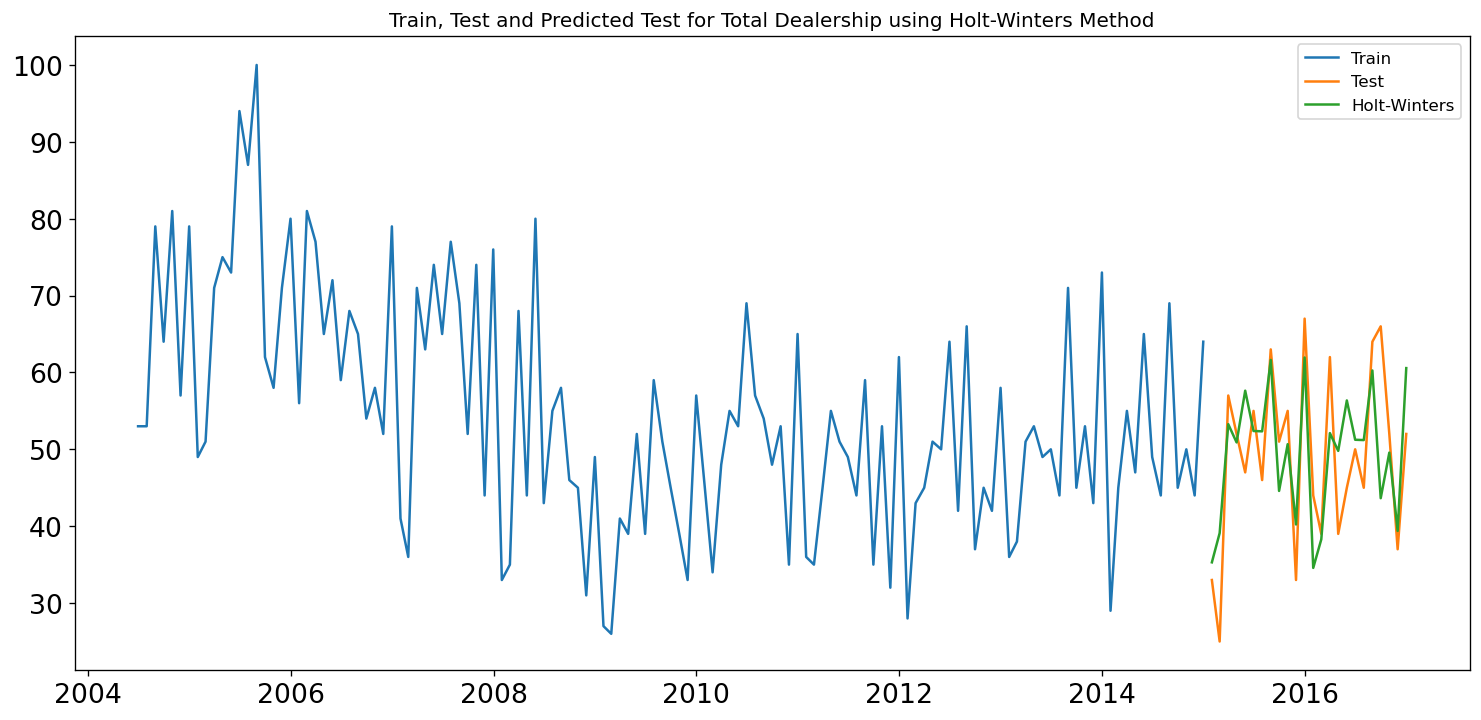

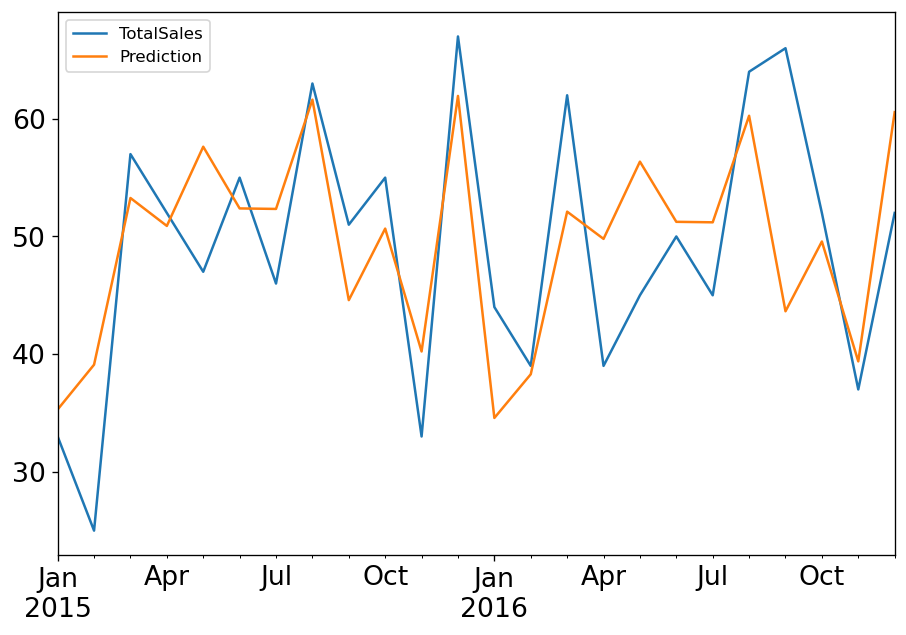

In [34]:
#enter params from the output above into the model
rcParams['figure.figsize'] = 15, 7

df = read_csv('../data/processed/TotalSales.csv')
df.index = pd.date_range(start='2004-06', periods=154, freq='M')
df = df.drop(columns=['ContractYearMonth'])
df.index.freq = 'M'
train, test = df['2004':'2014'], df['2015':'2016']

#model = ExponentialSmoothing(params).fit()
model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12, damped=False)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=False)
pred = hw_model.forecast(24)

#plot prediction using model
plt.title('Train, Test and Predicted Test for Total Dealership using Holt-Winters Method')
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

#narrow in on prediction
test.plot(legend=True, label='Test', figsize=(9,6))
pred.plot(legend= True, label='Prediction', xlim = ['2015-01', '2016-12']);

#evaluation
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)
mape = cal_mape(test.TotalSales, pred)

#join results
DlrResults = pd.DataFrame({'Method':['Holt-Winters'], 'RMSE': [rmse],'MAPE': [mape]})
Dlr_MAPE_df = pd.concat([Dlr_MAPE_df, DlrResults])
Dlr_MAPE_df

#### Lexus Prediction

,Method,RMSE,MAPE
0,Simple Average,10.380000,22.993712
0,Naive,17.710000,43.719574
0,SARIMAX,8.428568,17.403573
0,Holt-Winters,7.993429,15.790187


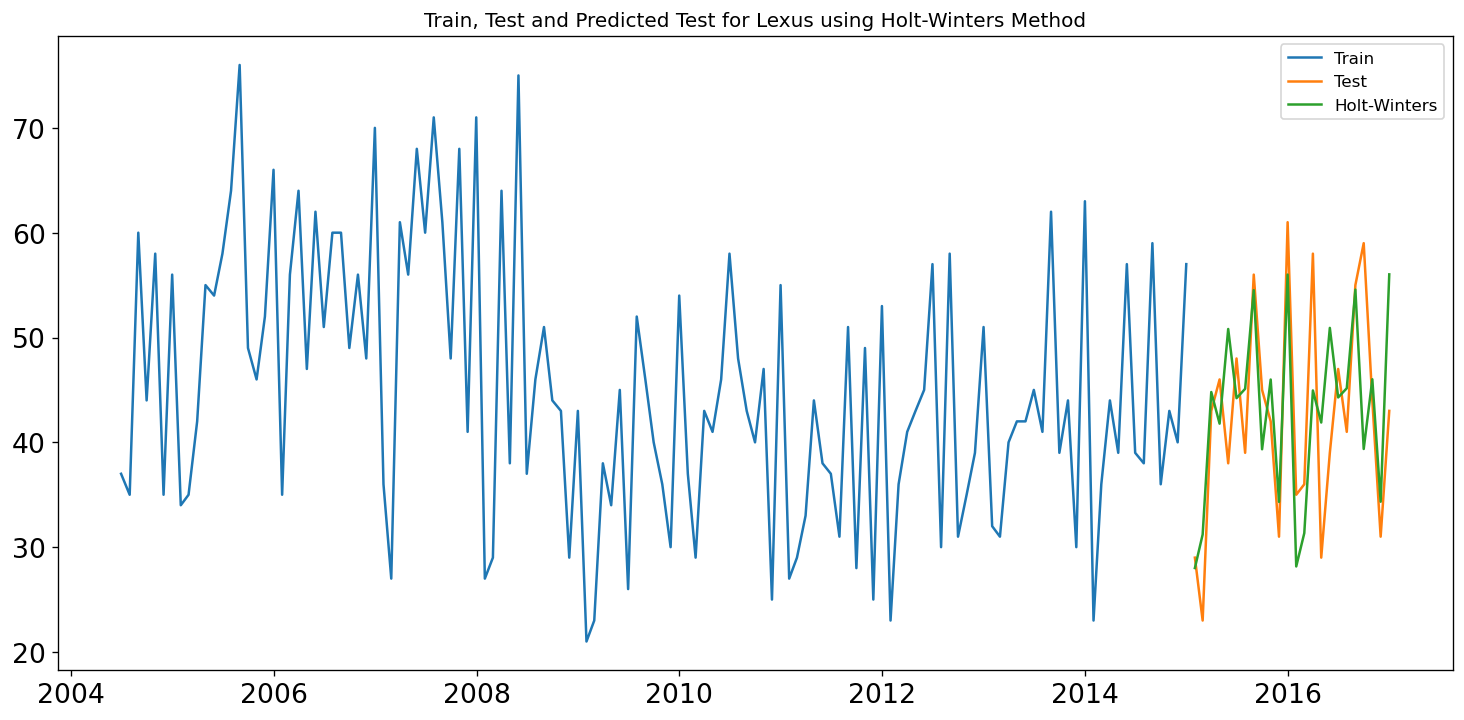

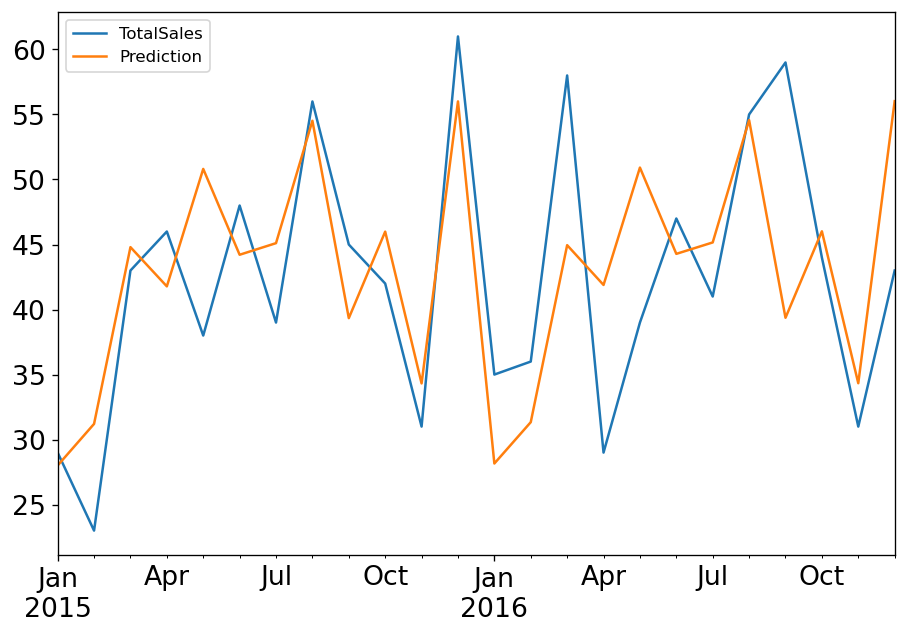

In [35]:
#enter params from the output above into the model
rcParams['figure.figsize'] = 15, 7

df2 = read_csv('../data/processed/LexusSales.csv')
df2.index = pd.date_range(start='2004-06', periods=154, freq='M')
df2 = df2.drop(columns=['ContractYearMonth'])
df2.index.freq = 'M'
train2, test2 = df2['2004':'2014'], df2['2015':'2016']
# model = ExponentialSmoothing(params).fit()
model2 = ExponentialSmoothing(train2, trend='mul', seasonal='mul', seasonal_periods=12, damped=True)
hw_model2 = model2.fit(optimized=True, use_boxcox=True, remove_bias=False)
pred2 = hw_model2.forecast(24)

#plot prediction using model
plt.title('Train, Test and Predicted Test for Lexus using Holt-Winters Method')
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(pred2.index, pred2, label='Holt-Winters')
plt.legend(loc='best')

#narrow in on prediction
test2.plot(legend=True, label='Test', figsize=(9,6))
pred2.plot(legend= True, label='Prediction', xlim = ['2015-01', '2016-12']);

#evaluation
mse = mean_squared_error(test2, pred2)
rmse = np.sqrt(mse)
mape = cal_mape(test2.TotalSales, pred2)

#join results
LxsResults = pd.DataFrame({'Method':['Holt-Winters'], 'RMSE': [rmse],'MAPE': [mape]})
Lxs_MAPE_df = pd.concat([Lxs_MAPE_df, LxsResults])
Lxs_MAPE_df

#### 4.6.5.3 Holt-Winter's Model Forecast

#### Dealership Forecast

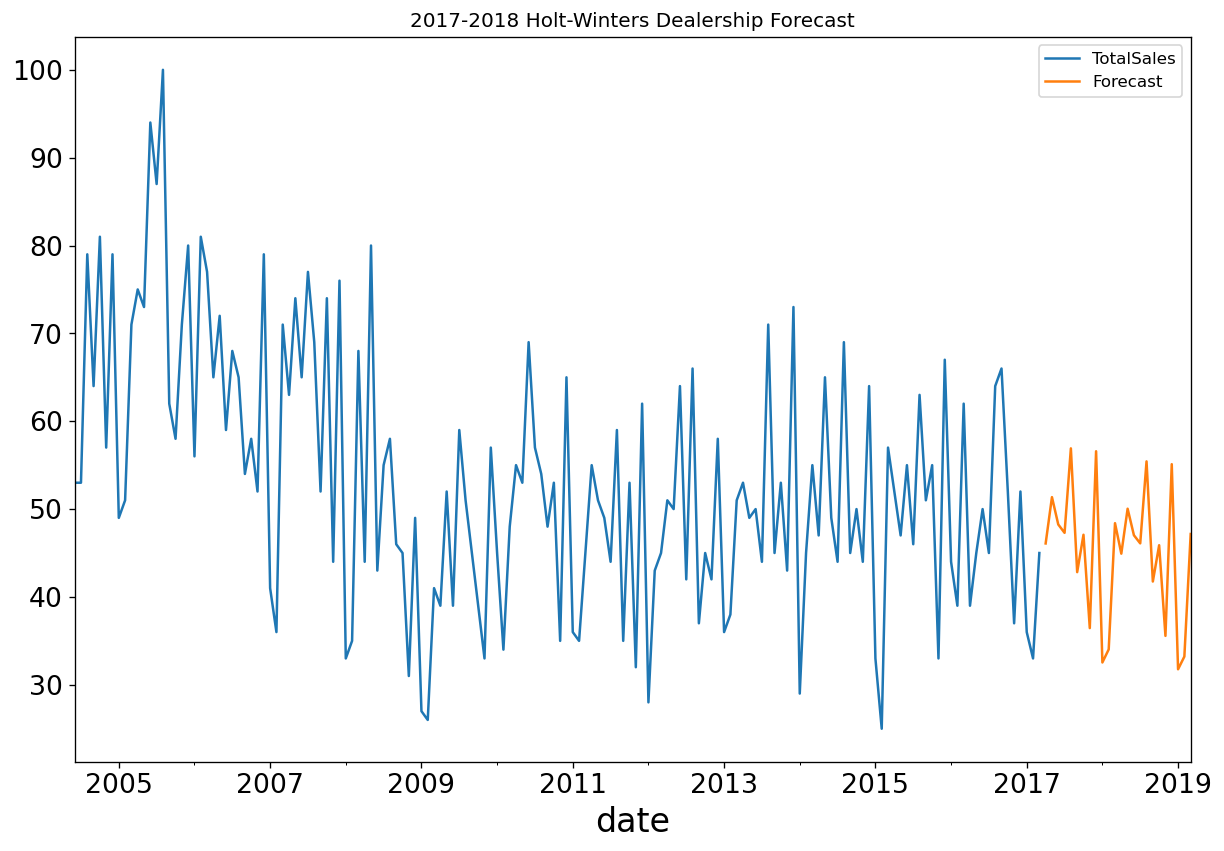

In [36]:
#define forecasting model
model = ExponentialSmoothing(df, trend='mul', seasonal='mul', seasonal_periods=12, damped=False)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=False)
final_model = hw_model.forecast(steps=24)
#plot model forecast 24 months into the future
ts_dt.plot(legend=True, label='Total Sales', figsize=(12,8))
final_model.plot(legend=True,label='Forecast')
plt.title('2017-2018 Holt-Winters Dealership Forecast');

#### Lexus Forecast

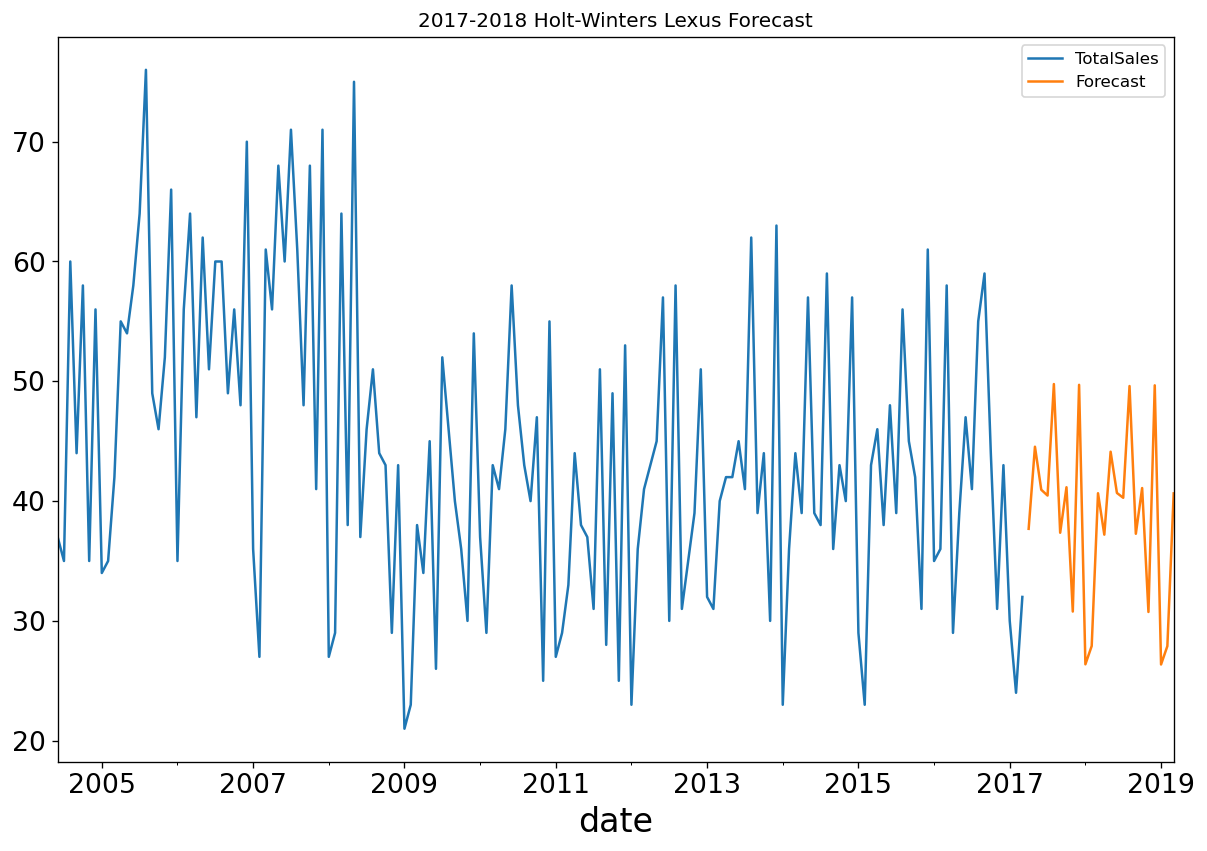

In [37]:
#define forecasting model
model_lex = ExponentialSmoothing(df2, trend='mul', seasonal='mul', seasonal_periods=12, damped=True)
hw_model_lex = model_lex.fit(optimized=True, use_boxcox=True, remove_bias=False)
final_model_lex = hw_model_lex.forecast(steps=24)
#plot model forecast 24 months into the future
lex.plot(legend=True, label='Lexus Sales', figsize=(12,8))
final_model_lex.plot(legend=True,label='Forecast')
plt.title('2017-2018 Holt-Winters Lexus Forecast');

## 4.7 Model Evaluation

#### Dealership Evaluations

In [38]:
Dlr_MAPE_df

,Method,RMSE,MAPE
0,Simple Average,12.170000,24.471189
0,Naive,18.470000,38.762770
0,SARIMAX,8.241263,14.562545
0,Holt-Winters,8.140466,14.206432


Out of the four baseline methods explored on the total dealership sales dataset, we can see the Naive method performed the best with a RMSE of 18.47 and a MAPE of about 39% accuracy.

#### Lexus Evaluations

In [39]:
Lxs_MAPE_df

,Method,RMSE,MAPE
0,Simple Average,10.380000,22.993712
0,Naive,17.710000,43.719574
0,SARIMAX,8.428568,17.403573
0,Holt-Winters,7.993429,15.790187


Out of the four baseline methods explored on the exclusive Lexus sales dataset, we can see again the Naive method performed the best with a RMSE of 17.71 and a MAPE of about 44% accuracy.